In [1]:
# Add the relevant scripts from LArMachineLearningData
# Nice the process so it can run with lots of cores on low priority
import os
os.nice(20)

# Add local paths
import sys
hnlDIR = os.environ['_']
sys.path.append('../pyscript')

# From pyscript Library
from Plotting import *
from Dictionary import *
from HelperFunctions import *
from CutFunctions import *

import pickle
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

import warnings
warnings.filterwarnings("ignore")

<h1>Configuration Stuff Here</h1>

In [2]:
m = 200

ifSave = False
savePath = "../plot_files/05Mar2024_m"+str(m)+"_systematics/"

In [3]:
unisim_list = [ 'slc_xsec_unisim_DecayAngMEC', 
               'slc_xsec_unisim_ThetaDelta2NRad',
               'slc_xsec_unisim_Theta_Delta2Npi', 
               'slc_xsec_unisim_VecFFCCQEshape',]

multisigma_list = [
        'slc_xsec_multisigma_CoulombCCQE',
       'slc_xsec_multisigma_NonRESBGvbarnCC1pi',
       'slc_xsec_multisigma_NonRESBGvbarnCC2pi',
       'slc_xsec_multisigma_NonRESBGvbarnNC1pi',
       'slc_xsec_multisigma_NonRESBGvbarnNC2pi',
       'slc_xsec_multisigma_NonRESBGvbarpCC1pi',
       'slc_xsec_multisigma_NonRESBGvbarpCC2pi',
       'slc_xsec_multisigma_NonRESBGvbarpNC1pi',
       'slc_xsec_multisigma_NonRESBGvbarpNC2pi',
       'slc_xsec_multisigma_NonRESBGvnCC1pi',
       'slc_xsec_multisigma_NonRESBGvnCC2pi',
       'slc_xsec_multisigma_NonRESBGvnNC1pi',
       'slc_xsec_multisigma_NonRESBGvnNC2pi',
       'slc_xsec_multisigma_NonRESBGvpCC1pi',
       'slc_xsec_multisigma_NonRESBGvpCC2pi',
       'slc_xsec_multisigma_NonRESBGvpNC1pi',
       'slc_xsec_multisigma_NonRESBGvpNC2pi', 
       'slc_xsec_multisigma_NormCCMEC',
       'slc_xsec_multisigma_NormNCMEC', 
       'slc_xsec_multisigma_RDecBR1eta',
       'slc_xsec_multisigma_RDecBR1gamma', 
       'slc_xsec_multisigma_RPA_CCQE',
       'slc_xsec_multisigma_NormNCCOH', 
       'slc_xsec_multisigma_NormCCCOH',
]

<h1> Read in PKL Dataframe </h1>

<h3>HNL</h3>

In [ ]:
hnl_path = "../pkl_files/v3/df_m"+str(m)+"_v3_hnl.pkl"

file = open(hnl_path, 'rb')
df_hnl = pickle.load(file)
file.close
del hnl_path

In [ ]:
df_hnl = df_hnl[["run", "subrun", "event", "slc_idx", "scale_pot", "simU", "scaledU", "mod_t", 'slc_comp', 'slc_true_event_type']]

<h3>TPC Neutrino</h3>

In [ ]:
nu_path = "../pkl_files/v3/df_m"+str(m)+"_v3_nu.pkl"

file = open(nu_path, 'rb')
df_nu = pickle.load(file)
file.close
del nu_path

In [ ]:
df_nu = df_nu[["run", "subrun", "event", "slc_idx", "scale_pot", "mod_t", 'slc_comp', 'slc_true_event_type']]

<h3>Intime Cosmics</h3>

In [ ]:
cos_path = "../pkl_files/v3/df_m"+str(m)+"_v3_cos.pkl"

file = open(cos_path, 'rb')
df_cos = pickle.load(file)
file.close
del cos_path

In [ ]:
df_cos = df_cos[["run", "subrun", "event", "slc_idx", "scale_pot", "mod_t", 'slc_comp', 'slc_true_event_type']]

<h1> Load Flux Systematics</h1>

<h3> HNL </h3>

In [ ]:
dfw_hnl = pd.DataFrame()

print(len(df_hnl))

for i in range(0, 3):  
    hnl_path = "../pkl_files/v3/hnl_m"+str(m)+"_50k_v3_flxw_{}.pkl".format(i)
    print(hnl_path)
    
    file = open(hnl_path, 'rb')   
    df = pickle.load(file)
    df = df[['run','subrun','event','slc_idx','slc_flux_weight_total']]

    print(df[(df['run'] == 1) & (df['subrun']==790) & (df['event']==39)])
    
    df = df.merge(df_hnl, how='inner', on=['run','subrun','event','slc_idx'])
    
    print(len(df))
    print(len(df_hnl))
    dfw_hnl = pd.concat((dfw_hnl, df), ignore_index=True)
    file.close()
    
del df_hnl

print(len(dfw_hnl))

<h3> TPC Neutrino </h3>

In [ ]:
dfw_nu = pd.DataFrame()

print(len(df_nu))

for i in range(0, 13):
    nu_path = "../pkl_files/v3/rockbox_100k_v3_flxw_{}.pkl".format(i)
    print(nu_path)
    
    file = open(nu_path, 'rb')
    df = pickle.load(file)
    df = df.merge(df_nu, how='inner', on=['run','subrun','event','slc_idx'])
    
    dfw_nu = pd.concat((dfw_nu, df), ignore_index=True)
    file.close()
    
del df_nu

print(len(dfw_nu))

<h1>Manipulate Dataframe</h1>

<h3>Flux Weights </h3>

In [ ]:
def make_df_flxw(df):
    
    #explode array into columns
    df_flxw = pd.DataFrame(df['slc_flux_weight_total'].tolist(),index=df.index).add_prefix('flxw_')
    
    #drop column
    df = df.drop(columns='slc_flux_weight_total')

    #merge 2 arrays together
    df = pd.concat([df, df_flxw], axis = 1)
    
    #add nominal flux weight = 1
    df['flxw_nom'] = 1
    
    del df_flxw
    return df

In [ ]:
dfw_hnl = make_df_flxw(dfw_hnl)
dfw_nu = make_df_flxw(dfw_nu)

In [ ]:
#Check for NAN for cosmic slice
nan_df = dfw_hnl[dfw_hnl.flxw_0 != dfw_hnl.flxw_0]
nan_df

In [ ]:
#fill NAN with 1
dfw_hnl = dfw_hnl.fillna(1)
dfw_hnl

<h3>Neutrino Cross Section Systematics</h3>

In [ ]:
def check_unisim(row):
    val = 1
    if len(row) > 0:
        val = row[0]
        if val == -9999:
            val = 1
    return val

In [ ]:
def check_multisigma_neg1(row):
    val = 1
    if len(row) > 0:
        val = row[0]
        if val == -9999:
            val = 1
    return val

In [ ]:
def check_multisigma_pos1(row):
    val = 1
    if len(row) > 0:
        val = row[1]
        if val == -9999:
            val = 1
    return val

In [ ]:
def make_df_xsecw(df):
    
    for name in unisim_list:
        df[name] = df[name].apply(lambda row: check_unisim(row))
    
    for name in multisigma_list:
        df[name+'_neg1'] = df[name].apply(lambda row: check_multisigma_neg1(row))
        df[name+'_pos1'] = df[name].apply(lambda row: check_multisigma_pos1(row))
        df = df.drop([name], axis = 1)
    
    #explode array into columns
    df_xsecw = pd.DataFrame(df['slc_xsec_multisim_total'].tolist(),index=df.index).add_prefix('xsecw_')
    
    #drop column
    df = df.drop(columns='slc_xsec_multisim_total')

    #merge 2 arrays together
    df = pd.concat([df, df_xsecw], axis = 1)
    
    #add nominal flux weight = 1
    df['xsec_nom'] = 1
    
    #explode array into columns
    df_g4w = pd.DataFrame(df['slc_geant4_multisim_reinteractions'].tolist(),index=df.index).add_prefix('g4w_')
    
    #drop column
    df = df.drop(columns='slc_geant4_multisim_reinteractions')

    #merge 2 arrays together
    df = pd.concat([df, df_g4w], axis = 1)
    
    #add nominal flux weight = 1
    df['g4_nom'] = 1
    
    return df


In [ ]:
dfw_nu = make_df_xsecw(dfw_nu)

In [ ]:
#fill cosmic weight with 1
dfw_nu = dfw_nu.fillna(1)
dfw_nu

In [ ]:
for name in multisigma_list:
    print()
    print(dfw_nu[name + "_pos1"])
    print(dfw_nu[name + "_neg1"])

<h1>SAVE THIS DATAFRAME</h1>

In [ ]:
dfw_hnl.to_pickle("../pkl_files/v3/df_hnl_m"+str(m)+"_v3_weight.pkl", protocol = 5)
dfw_nu.to_pickle("../pkl_files/v3/df_nu_m"+str(m)+"_v3_weight.pkl", protocol = 5)
df_cos.to_pickle("../pkl_files/v3/df_cos_m"+str(m)+"_v3_weight.pkl", protocol = 5)

<h1> START FROM HERE!!! LOAD PKL FILE WITH FLX WEIGHT ADDED </h1>

<h3>HNL</h3>

In [4]:
file = open("../pkl_files/v3/df_hnl_m"+str(m)+"_v3_weight.pkl", 'rb')
df_hnl = pickle.load(file)
file.close()

<h3>TPC Neutrino</h3>

In [5]:
file = open("../pkl_files/v3/df_nu_m"+str(m)+"_v3_weight.pkl", 'rb')
df_nu = pickle.load(file)
file.close()

<h3>Intime Cosmics</h3>

In [6]:
file = open("../pkl_files/v3/df_cos_m"+str(m)+"_v3_weight.pkl", 'rb')
df_cos = pickle.load(file)
file.close()

<h3> Configure some plots stuff </h3> 

In [7]:
xmin = 0
xmax = 19
xnbin = 19

hnl_ymin = 0
hnl_ymax = 1200

nu_ymin = 0
nu_ymax = 60

<h3> Organise Some Stuff</h3>

In [8]:
hnl_dict = {}
nu_dict = {}

<h1> Make Beam Bucket - Post PID</h1>

In [9]:
true_counts = 1
start_counts = 1
simU = 1

if m == 140:
    simU = 1e-5
    scaleHNLPlot = 3.7
    true_counts = 32240.456491241213
    start_counts = 30011.11138541757
    
if m == 200:
    simU=1e-7
    scaleHNLPlot = 80
    true_counts = 1491.8413161003443
    start_counts = 1372.3745440402568
    
if m == 240:
    simU = 1e-7
    scaleHNLPlot = 17.2
    true_counts = 6935.57810442791
    start_counts = 6380.176454423673

In [10]:
plotU = df_hnl['scaledU'].unique()[0]

true_counts = true_counts * scaleHNLPlot
start_counts =  start_counts * scaleHNLPlot

print("Scale Umu by " + str(scaleHNLPlot))
print("Scaled Umu = " + str(plotU))
print("Scaled true counts = " + str(true_counts))
print("Scaled start counts = " + str(start_counts))

Scale Umu by 80
Scaled Umu = 8.944271909999158e-07
Scaled true counts = 119347.30528802755
Scaled start counts = 109789.96352322053


In [11]:
width = 18.936

hist, bins = plot_slc_var(df_hnl, df_nu, df_cos,
                    true_counts, start_counts, 
                    'mod_t', 
                    xmin = xmin, xmax = xmax, xnbin = xnbin,
                    xtitle = 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]'
                    )
plt.show()

KeyError: "['slc_id'] not in index"

<h1>Statistics Uncertainty</h1>

<h3>HNL</h3>

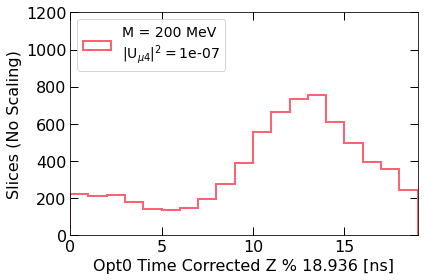

In [12]:
fig, ax1 = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax

pltdf = df_hnl['mod_t']
weights = None

#-----------------------------------------------------------------#
hnl_stat_noScale, bins, _ = ax1.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["Flamingo"],
                            linestyle = "-",
                            linewidth = 2,
                            label = "M = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(simU))
                        )

ax1.legend(loc = 'upper left',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(hnl_ymin, hnl_ymax)

#-----------------------------------------------------------------#
fig.tight_layout()

plt.show()

In [13]:
#No Scale
print("\nprescale: entries per bin")
print(hnl_stat_noScale)

print("\nprescale: sqrt(entries) per bin")
hnl_stat_noScale_err = np.sqrt(hnl_stat_noScale)
print(hnl_stat_noScale_err)

print("\nprescale: fractional error = sqrt(entries) per bin/ entries per bin")
hnl_stat_rel_err = hnl_stat_noScale_err / hnl_stat_noScale
print(hnl_stat_rel_err)


prescale: entries per bin
[225. 210. 216. 181. 142. 136. 145. 193. 278. 390. 555. 665. 735. 756.
 608. 499. 395. 357. 244.]

prescale: sqrt(entries) per bin
[15.         14.49137675 14.69693846 13.45362405 11.91637529 11.66190379
 12.04159458 13.89244399 16.673332   19.74841766 23.55843798 25.78759392
 27.11088342 27.49545417 24.65765601 22.3383079  19.87460691 18.89444363
 15.62049935]

prescale: fractional error = sqrt(entries) per bin/ entries per bin
[0.06666667 0.06900656 0.06804138 0.07432941 0.08391814 0.08574929
 0.08304548 0.07198158 0.05997601 0.05063697 0.04244764 0.03877834
 0.03688556 0.03636965 0.04055536 0.04476615 0.05031546 0.05292561
 0.06401844]


In [14]:
#This is the smart way
cov = np.diag(hnl_stat_noScale) #[some NxN covariance matrix e.g. np.diag(cv) for statistical]
fractional = cov / np.outer(hnl_stat_noScale, hnl_stat_noScale) # N / (N * N)
fractional_err = np.sqrt(np.diag(fractional)) # sqrt(N)
fractional_err

array([0.06666667, 0.06900656, 0.06804138, 0.07432941, 0.08391814,
       0.08574929, 0.08304548, 0.07198158, 0.05997601, 0.05063697,
       0.04244764, 0.03877834, 0.03688556, 0.03636965, 0.04055536,
       0.04476615, 0.05031546, 0.05292561, 0.06401844])

In [15]:
hnl_stat_noScale_plot = np.insert(hnl_stat_noScale, 0, 0)

bins_mid = np.convolve(bins, [0.5, 0.5], "valid")

In [16]:
hnl_dict['hnl_cv'] = hnl_stat_noScale
hnl_dict['hnl_cv_plot'] = hnl_stat_noScale_plot

hnl_dict['bins'] = bins
hnl_dict['bins_mid'] = bins_mid

hnl_dict['neg_stat_err']= hnl_stat_noScale_err
hnl_dict['pos_stat_err']= hnl_stat_noScale_err

hnl_dict

{'hnl_cv': array([225., 210., 216., 181., 142., 136., 145., 193., 278., 390., 555.,
        665., 735., 756., 608., 499., 395., 357., 244.]),
 'hnl_cv_plot': array([  0., 225., 210., 216., 181., 142., 136., 145., 193., 278., 390.,
        555., 665., 735., 756., 608., 499., 395., 357., 244.]),
 'bins': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 'bins_mid': array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 'neg_stat_err': array([15.        , 14.49137675, 14.69693846, 13.45362405, 11.91637529,
        11.66190379, 12.04159458, 13.89244399, 16.673332  , 19.74841766,
        23.55843798, 25.78759392, 27.11088342, 27.49545417, 24.65765601,
        22.3383079 , 19.87460691, 18.89444363, 15.62049935]),
 'pos_stat_err': array([15.        , 14.49137675, 14.69693846, 13.45362405, 11.91637529,
        11.66190379, 12.04159458, 13.89244399, 16

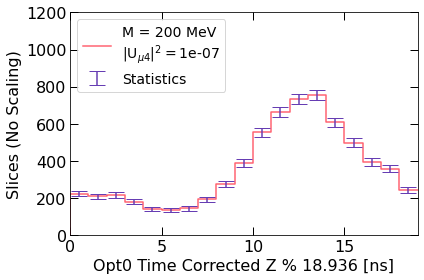

In [17]:
fig, (ax1) = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax

#-----------------------------------------------------------------#
#nStat NoScale
ax1.step(bins, hnl_stat_noScale_plot
         , color = col_dict['Flamingo']
         , label =  "M = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(simU))
        )

ax1.errorbar(bins_mid, hnl_stat_noScale, hnl_stat_noScale_err,
            ls='none',
            color = col_dict['Mauve'],
            capsize=8
            ,label = "Statistics"
           )
#-----------------------------------------------------------------#

ax1.legend(loc = 'upper left',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(hnl_ymin, hnl_ymax)

#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_statistics_error.png"), dpi=200)
    
plt.show()

<h3>Neutrino</h3>

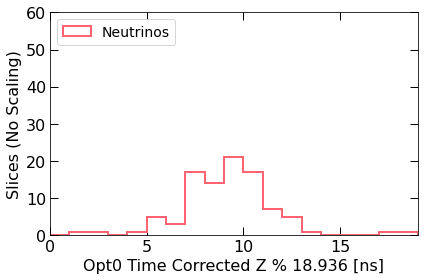

In [18]:
fig, (ax1) = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax

pltdf = df_nu['mod_t']
weights = None

#-----------------------------------------------------------------#
nu_stat_noScale, bins, _ = ax1.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["Flamingo"],
                            linestyle = "-",
                            linewidth = 2,
                            label = "Neutrinos"
                        )

ax1.legend(loc = 'upper left',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(nu_ymin, nu_ymax)

#-----------------------------------------------------------------#
fig.tight_layout()

plt.show()

In [19]:
#No Scale
print("\nprescale: entries per bin")
print(nu_stat_noScale)

print("\nprescale: sqrt(entries) per bin")
nu_stat_noScale_err = np.sqrt(nu_stat_noScale)
print(nu_stat_noScale_err)

print("\nprescale: fractional error = sqrt(entries) per bin/ entries per bin")
nu_stat_rel_err = nu_stat_noScale_err / nu_stat_noScale
#fill nan with 0
nu_stat_rel_err = np.nan_to_num(nu_stat_rel_err, nan=0)
print(nu_stat_rel_err)


prescale: entries per bin
[ 0.  1.  1.  0.  1.  5.  3. 17. 14. 21. 17.  7.  5.  1.  0.  0.  0.  1.
  1.]

prescale: sqrt(entries) per bin
[0.         1.         1.         0.         1.         2.23606798
 1.73205081 4.12310563 3.74165739 4.58257569 4.12310563 2.64575131
 2.23606798 1.         0.         0.         0.         1.
 1.        ]

prescale: fractional error = sqrt(entries) per bin/ entries per bin
[0.         1.         1.         0.         1.         0.4472136
 0.57735027 0.24253563 0.26726124 0.21821789 0.24253563 0.37796447
 0.4472136  1.         0.         0.         0.         1.
 1.        ]


In [20]:
nu_stat_noScale_plot = np.insert(nu_stat_noScale, 0, 0)


In [21]:
nu_dict['nu_cv'] = nu_stat_noScale
nu_dict['nu_cv_plot'] = nu_stat_noScale_plot

nu_dict['bins'] = bins
nu_dict['bins_mid'] = bins_mid

nu_dict['neg_stat_err']= nu_stat_noScale_err
nu_dict['pos_stat_err']= nu_stat_noScale_err

nu_dict

{'nu_cv': array([ 0.,  1.,  1.,  0.,  1.,  5.,  3., 17., 14., 21., 17.,  7.,  5.,
         1.,  0.,  0.,  0.,  1.,  1.]),
 'nu_cv_plot': array([ 0.,  0.,  1.,  1.,  0.,  1.,  5.,  3., 17., 14., 21., 17.,  7.,
         5.,  1.,  0.,  0.,  0.,  1.,  1.]),
 'bins': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 'bins_mid': array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 'neg_stat_err': array([0.        , 1.        , 1.        , 0.        , 1.        ,
        2.23606798, 1.73205081, 4.12310563, 3.74165739, 4.58257569,
        4.12310563, 2.64575131, 2.23606798, 1.        , 0.        ,
        0.        , 0.        , 1.        , 1.        ]),
 'pos_stat_err': array([0.        , 1.        , 1.        , 0.        , 1.        ,
        2.23606798, 1.73205081, 4.12310563, 3.74165739, 4.58257569,
        4.12310563, 2.64575131, 2.23606798, 1.

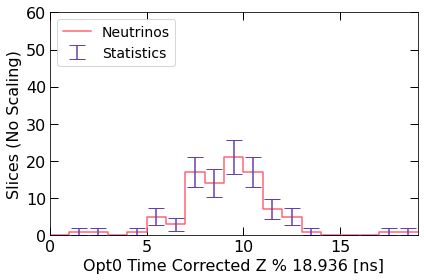

In [22]:
fig, (ax1) = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax

#-----------------------------------------------------------------#
#nStat NoScale
ax1.step(bins, nu_stat_noScale_plot
         , color = col_dict['Flamingo']
         , label =  "Neutrinos"
        )

ax1.errorbar(bins_mid, nu_stat_noScale, nu_stat_noScale_err,
            ls='none',
            color = col_dict['Mauve'],
            capsize=8
            ,label = "Statistics"
           )
#-----------------------------------------------------------------#

ax1.legend(loc = 'upper left',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(hnl_ymin, 60)

#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_statistics_error.png"), dpi=200)
    
plt.show()

<h1>Flux Weights</h1>

<h3>Calculate Median and Value at 68 percentile</h3>

In [23]:
def get_median_68_quantile(n_cv, n_arr):
    print("CV array")
    n_cv = np.array(n_cv)
    print(n_cv)

    #check shape
    print("Weight array shape")
    n_arr = np.array(n_arr)
    print(n_arr.shape)

    print('\n Median')
    print(np.median(n_arr, axis=0))
    median = np.median(n_arr, axis=0)
    
    print('\n Low 34.1 quantile')
    print(np.percentile(n_arr, 15.87, axis=0))
    low_flux = np.percentile(n_arr, 15.87, axis=0)

    print('\n High 34.1 quantile')
    print(np.percentile(n_arr, 84.13, axis=0))
    high_flux = np.percentile(n_arr, 84.13, axis=0)

    print('\n Standard Error')
    flx_err = [abs(n_cv - low_flux), abs(high_flux - n_cv)]
    flx_err = np.array(flx_err)
    print(flx_err)
    
    median = np.array(median)
    flx_err = np.array(flx_err)
    return median, flx_err

In [24]:
def get_cov_corr_matrix(cv, universe):

    print(cv.shape)
    print(universe.shape)
    
    #construct covariance matrix
    cov = np.cov(np.subtract(cv[np.newaxis,:], universe).transpose())

    #error = sqrt(diag)
    err = np.sqrt(np.diagonal(cov))

    #construct correlation matrix
    corr = cov/np.outer(err, err)  
    
    return cov, corr

<h3>HNL</h3>

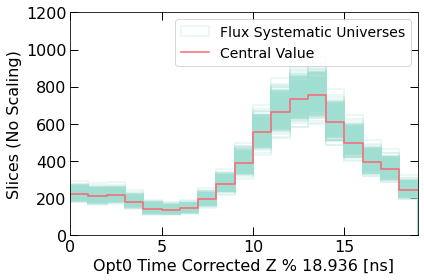

In [25]:
hnl_flx_universe = []

fig, ax = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#-----------------------------------------------------------------#
#Universe
pltdf = df_hnl['mod_t']

for i in range(0, 1000):
    weights = df_hnl['flxw_{}'.format(i)]
    label = ''
    if i == 0:
        label = "Flux Systematic Universes"
        
    hnl_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["PastelGreen"],
                            alpha = 0.2,
                            linestyle = "-",
                            linewidth = 2,
                            label = label
                        )
    hnl_flx_universe.append(hnl_n)
#-----------------------------------------------------------------#
#Central Value
ax.step(bins, hnl_dict['hnl_cv_plot']
         , color = col_dict['Flamingo']
         , label =  "Central Value"
        )
#-----------------------------------------------------------------#
ax.legend(loc = 'upper right',fontsize = 14)

plot_tick(ax, 16)
plot_title(ax, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax.set_xlim(xmin, xmax)
ax.set_ylim(hnl_ymin, hnl_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_flux_weight_universe.png"), dpi=200)
plt.show()

<h3>Median and 68% Quantile</h3>

In [26]:
hnl_flx_universe = np.array(hnl_flx_universe)
hnl_flx_universe = np.sort(hnl_flx_universe, axis = 0)

hnl_flx_median, hnl_flx_err = get_median_68_quantile(hnl_dict['hnl_cv'], hnl_flx_universe)

#make array for plotting
hnl_flx_median_plot = np.insert(hnl_flx_median, 0, 0)

CV array
[225. 210. 216. 181. 142. 136. 145. 193. 278. 390. 555. 665. 735. 756.
 608. 499. 395. 357. 244.]
Weight array shape
(1000, 19)

 Median
[225.29500216 214.04362676 217.22259632 184.53162503 145.69352743
 139.50576442 147.10399115 194.18328911 279.16389316 392.37133563
 555.8453005  667.32073595 736.5566898  756.03967723 612.52815336
 505.86881799 399.21383283 359.22799525 248.14063528]

 Low 34.1 quantile
[210.17763819 198.10476554 202.94023361 171.52037927 134.37843264
 130.37249945 137.27041784 179.82144889 261.06418034 366.07233311
 519.4344927  624.4467359  689.48281588 708.45945837 573.06191463
 472.71282994 373.67018358 336.14738399 230.19099776]

 High 34.1 quantile
[241.81393034 231.65941564 233.39425395 198.8975497  158.57957672
 149.56415798 157.3170613  208.80773705 298.04061695 419.03085778
 593.09618729 712.08818858 785.53752051 805.9344313  653.11531677
 539.91771763 427.39619083 385.18884532 266.72236705]

 Standard Error
[[14.82236181 11.89523446 13.05976639  9

In [27]:
hnl_dict['neg_flx_err'] = hnl_flx_err[0]
hnl_dict['pos_flx_err'] = hnl_flx_err[1]

hnl_dict

{'hnl_cv': array([225., 210., 216., 181., 142., 136., 145., 193., 278., 390., 555.,
        665., 735., 756., 608., 499., 395., 357., 244.]),
 'hnl_cv_plot': array([  0., 225., 210., 216., 181., 142., 136., 145., 193., 278., 390.,
        555., 665., 735., 756., 608., 499., 395., 357., 244.]),
 'bins': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 'bins_mid': array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 'neg_stat_err': array([15.        , 14.49137675, 14.69693846, 13.45362405, 11.91637529,
        11.66190379, 12.04159458, 13.89244399, 16.673332  , 19.74841766,
        23.55843798, 25.78759392, 27.11088342, 27.49545417, 24.65765601,
        22.3383079 , 19.87460691, 18.89444363, 15.62049935]),
 'pos_stat_err': array([15.        , 14.49137675, 14.69693846, 13.45362405, 11.91637529,
        11.66190379, 12.04159458, 13.89244399, 16

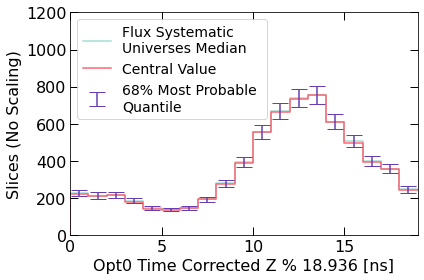

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#median
ax.step(bins, hnl_flx_median_plot, color = col_dict['PastelGreen'], label = "Flux Systematic \nUniverses Median")
#-----------------------------------------------------------------#
#central value
ax.step(bins, hnl_dict['hnl_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_flx_err'], hnl_dict['pos_flx_err']]
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            ,label = "68% Most Probable \nQuantile"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax, 16)

ax.legend(loc="upper left", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(hnl_ymin, hnl_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()
if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_flux_weight_median68.png"), dpi=200)
plt.show()

<h3>Covariance Matrix</h3>

In [29]:
hnl_flux_cov, _ = get_cov_corr_matrix(hnl_dict['hnl_cv'], hnl_flx_universe)

(19,)
(1000, 19)


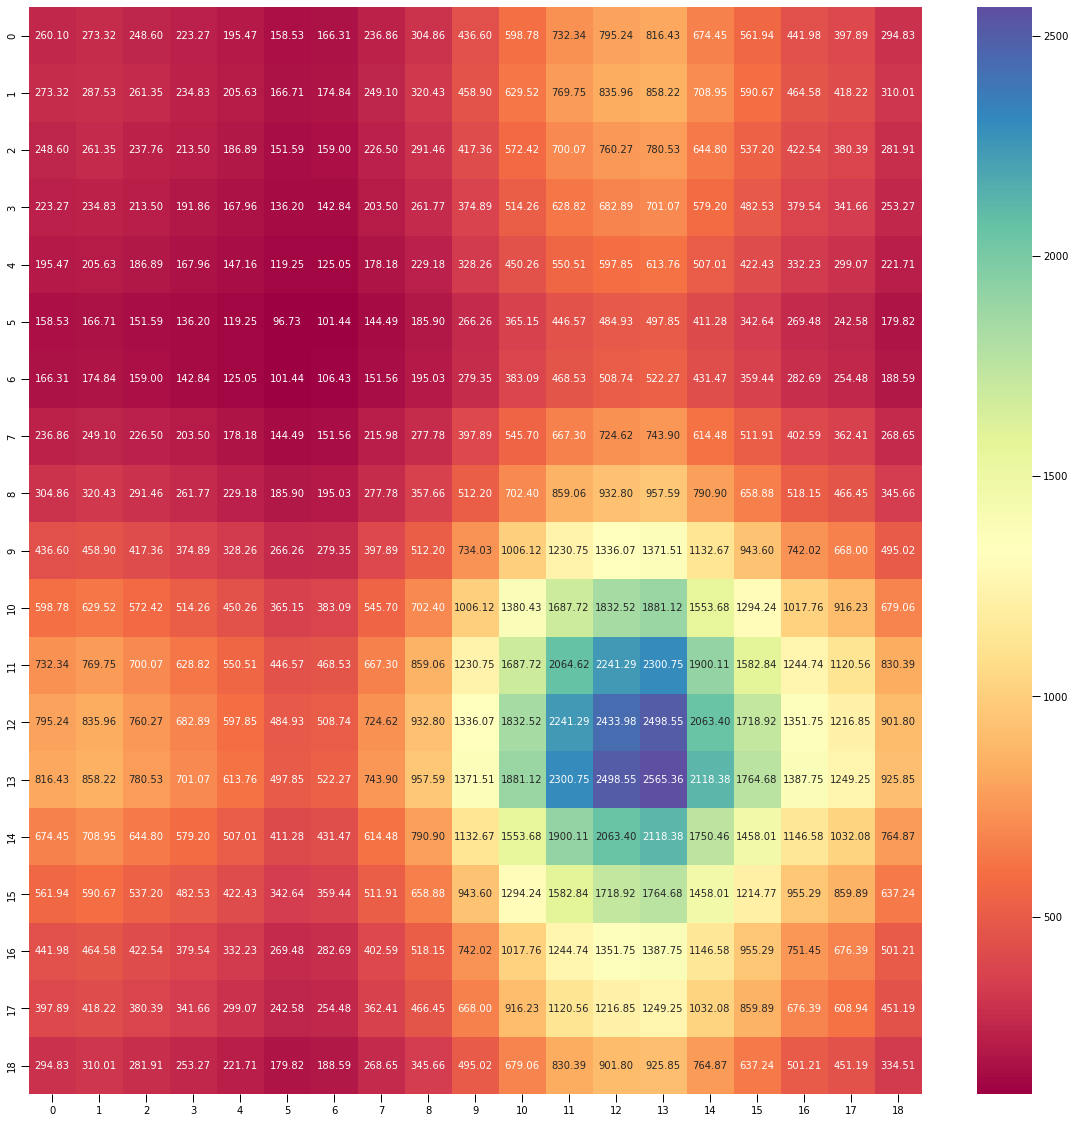

In [30]:
fig, ax = plt.subplots(1,1, figsize = (20, 20))

ax = sns.heatmap(hnl_flux_cov, annot=True, fmt='.2f', cmap = "Spectral")
plt.show()

In [31]:
hnl_dict['cov_flx_err'] = np.sqrt(np.diag(hnl_flux_cov))

<h3>Comparison</h3>

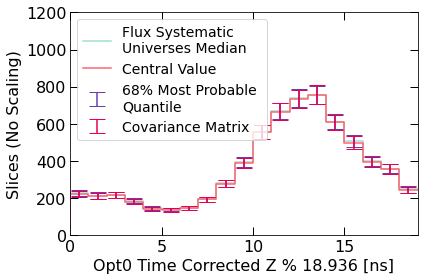

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#median
ax.step(bins, hnl_flx_median_plot, color = col_dict['PastelGreen'], label = "Flux Systematic \nUniverses Median")
#-----------------------------------------------------------------#
#central value
ax.step(bins, hnl_dict['hnl_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_flx_err'], hnl_dict['pos_flx_err']]
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            ,label = "68% Most Probable \nQuantile"
           )
#-----------------------------------------------------------------#
#covariance matrix
ax.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['cov_flx_err'], hnl_dict['cov_flx_err']]
            , ls='none'
            , color = col_dict['Coral']
            , capsize=8
            ,label = "Covariance Matrix"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax, 16)

ax.legend(loc="upper left", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(hnl_ymin, hnl_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()
if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_flux_weight_median68.png"), dpi=200)
plt.show()

<h3>Neutrino</h3>

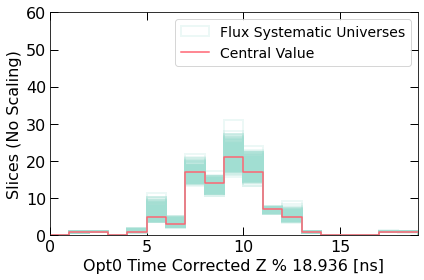

In [33]:
nu_flx_universe = []

fig, ax = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#-----------------------------------------------------------------#
#Universe
pltdf = df_nu['mod_t']

for i in range(0, 1000):
    weights = df_nu['flxw_{}'.format(i)]
    label = ''
    if i == 0:
        label = "Flux Systematic Universes"
        
    nu_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["PastelGreen"],
                            alpha = 0.2,
                            linestyle = "-",
                            linewidth = 2,
                            label = label
                        )
    nu_flx_universe.append(nu_n)
#-----------------------------------------------------------------#
#Central Value
ax.step(bins, nu_dict['nu_cv_plot']
         , color = col_dict['Flamingo']
         , label =  "Central Value"
        )
#-----------------------------------------------------------------#
ax.legend(loc = 'upper right',fontsize = 14)

plot_tick(ax, 16)
plot_title(ax, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_flux_weight_universe.png"), dpi=200)
plt.show()

In [34]:
nu_flx_universe = np.array(nu_flx_universe)
nu_flx_universe = np.sort(nu_flx_universe, axis = 0)

nu_flx_median, nu_flx_err = get_median_68_quantile(nu_dict['nu_cv'], nu_flx_universe)

#make array for plotting
nu_flx_median_plot = np.insert(nu_flx_median, 0, 0)

CV array
[ 0.  1.  1.  0.  1.  5.  3. 17. 14. 21. 17.  7.  5.  1.  0.  0.  0.  1.
  1.]
Weight array shape
(1000, 19)

 Median
[ 0.          0.91168696  1.00912637  0.          1.26771295  5.40754461
  3.35664177 16.39604473 13.44812775 20.94083595 17.82060814  6.76805115
  5.13859558  0.83668518  0.          0.          0.          1.04319763
  0.96121216]

 Low 34.1 quantile
[ 0.          0.80660161  0.9728841   0.          1.06779105  4.56638529
  2.86756701 15.27424238 12.49141208 19.04679338 16.21923175  6.41588992
  4.50300137  0.72339532  0.          0.          0.          0.97365613
  0.89394183]

 High 34.1 quantile
[ 0.          1.02314999  1.0479826   0.          1.49051522  6.85100345
  3.9187012  17.6898493  14.38141678 23.16536034 19.52244587  7.12577985
  5.8157828   0.94533476  0.          0.          0.          1.11838356
  1.02990603]

 Standard Error
[[0.         0.19339839 0.0271159  0.         0.06779105 0.43361471
  0.13243299 1.72575762 1.50858792 1.95320662 0.

In [35]:
nu_dict['neg_flx_err'] = nu_flx_err[0]
nu_dict['pos_flx_err'] = nu_flx_err[1]

nu_dict

{'nu_cv': array([ 0.,  1.,  1.,  0.,  1.,  5.,  3., 17., 14., 21., 17.,  7.,  5.,
         1.,  0.,  0.,  0.,  1.,  1.]),
 'nu_cv_plot': array([ 0.,  0.,  1.,  1.,  0.,  1.,  5.,  3., 17., 14., 21., 17.,  7.,
         5.,  1.,  0.,  0.,  0.,  1.,  1.]),
 'bins': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 'bins_mid': array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 'neg_stat_err': array([0.        , 1.        , 1.        , 0.        , 1.        ,
        2.23606798, 1.73205081, 4.12310563, 3.74165739, 4.58257569,
        4.12310563, 2.64575131, 2.23606798, 1.        , 0.        ,
        0.        , 0.        , 1.        , 1.        ]),
 'pos_stat_err': array([0.        , 1.        , 1.        , 0.        , 1.        ,
        2.23606798, 1.73205081, 4.12310563, 3.74165739, 4.58257569,
        4.12310563, 2.64575131, 2.23606798, 1.

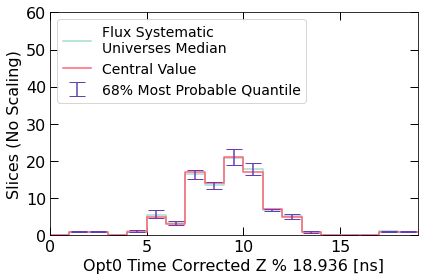

In [36]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#median
ax.step(bins, nu_flx_median_plot, color = col_dict['PastelGreen'], label = "Flux Systematic \nUniverses Median")
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_flx_err'] ,nu_dict['pos_flx_err']]
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            ,label = "68% Most Probable Quantile"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax, 16)

ax.legend(loc="upper left", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()
if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_flux_weight_median68.png"), dpi=200)
plt.show()

<h3>Covariance Matrix </h3>

In [37]:
nu_flux_cov, _ = get_cov_corr_matrix(nu_dict['nu_cv'], nu_flx_universe)

(19,)
(1000, 19)


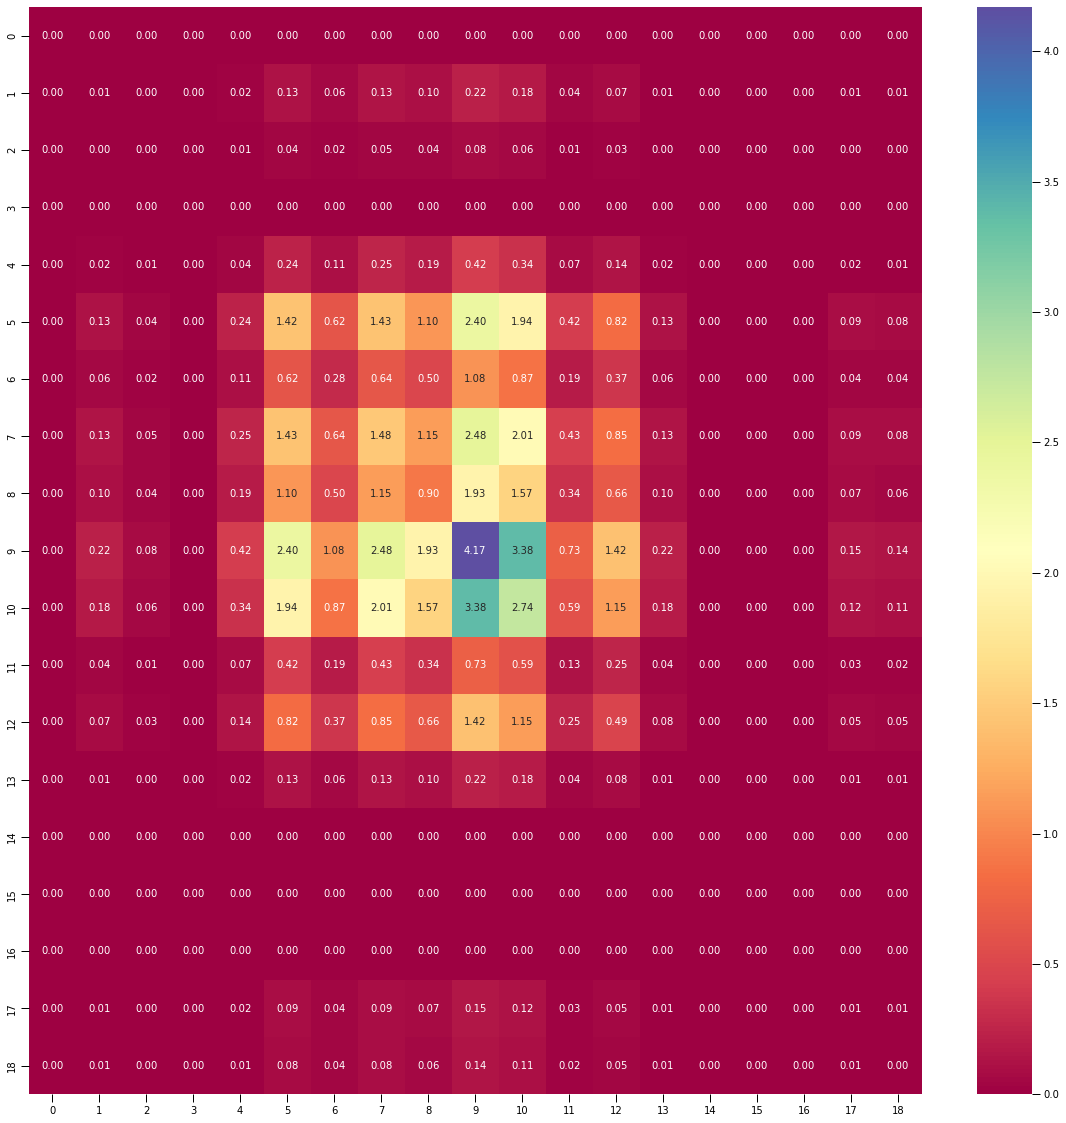

In [38]:
fig, ax = plt.subplots(1,1, figsize = (20, 20))

ax = sns.heatmap(nu_flux_cov, annot=True, fmt='.2f', cmap = "Spectral")
plt.show()

In [39]:
nu_dict['cov_flx_err'] = np.sqrt(np.diag(nu_flux_cov))

<h3>Comparison</h3>

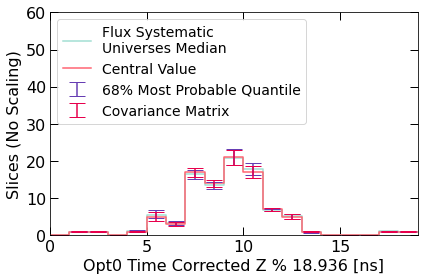

In [40]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#median
ax.step(bins, nu_flx_median_plot, color = col_dict['PastelGreen'], label = "Flux Systematic \nUniverses Median")
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_flx_err'] ,nu_dict['pos_flx_err']]
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            ,label = "68% Most Probable Quantile"
           )
#-----------------------------------------------------------------#
#covariance matrix
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['cov_flx_err'] ,nu_dict['cov_flx_err']]
            , ls='none'
            , color = col_dict['Coral']
            , capsize=8
            ,label = "Covariance Matrix"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax, 16)

ax.legend(loc="upper left", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()
if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_flux_weight_median68.png"), dpi=200)
plt.show()

<h1>Cross Section Weights</h1>

<h3>Uni Sim</h3>

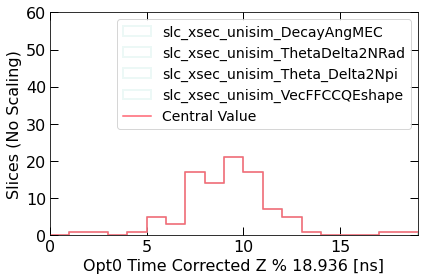

In [41]:
nu_unisim_arr = []

fig, ax = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#-----------------------------------------------------------------#
#Universe
pltdf = df_nu['mod_t']
weights = df_nu['xsec_nom']
    
for name in unisim_list:
    weights = df_nu[name]
    
    nu_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["PastelGreen"],
                            alpha = 0.2,
                            linestyle = "-",
                            linewidth = 2,
                            label = name
                        )
    nu_unisim_arr.append(nu_n)
    
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
ax.legend(loc = 'upper right',fontsize = 14)

plot_tick(ax, 16)
plot_title(ax, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_unisim_xsec_weight_universe.png"), dpi=200)
plt.show()

In [42]:
#Should be 4 unisim
nu_unisim_arr = np.array(nu_unisim_arr)
nu_unisim_err = nu_unisim_arr - nu_dict['nu_cv']
nu_unisim_err

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]])

In [43]:
#TODO: Unisim - IGNORE FOR NOW
#nu_err['neg_flx_err'] = nu_flx_err[0]
#nu_err

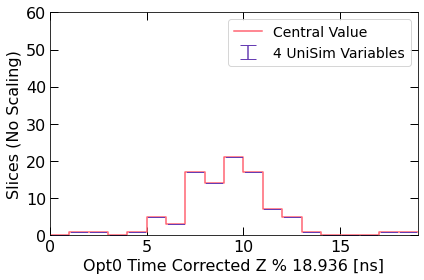

In [44]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

#-----------------------------------------------------------------#

#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#TODO: CURRENTLY PLOTTING 
#universe 1 sigma
for i in range(0, nu_unisim_err.shape[0]):
    label = ""
    if i == 0:
        label = '4 UniSim Variables'
    ax.errorbar(bins_mid, nu_dict['nu_cv']
                , yerr=(np.maximum(0, - nu_unisim_err[i]), np.maximum(0, nu_unisim_err[i]))
                , ls='none'
                , color = col_dict['Mauve']
                , capsize=8
                , label = label
                )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()
if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_weight_unisim_1direction.png"), dpi=200)
plt.show()

<h3>Multi Sigma - Take 1 Sigma Directly</h3>

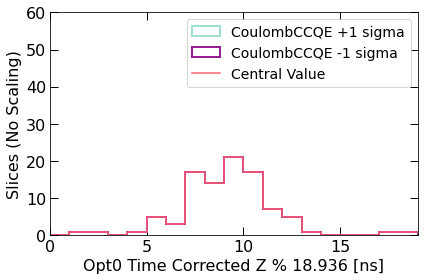

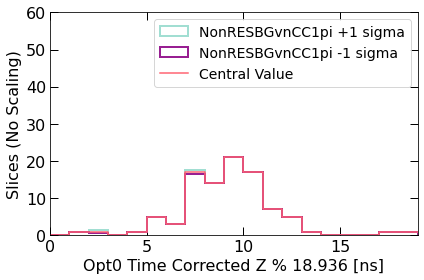

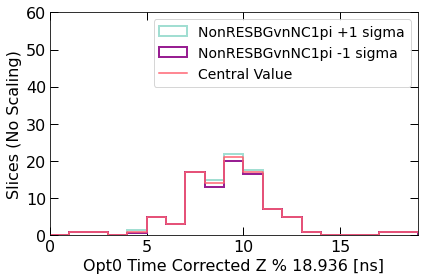

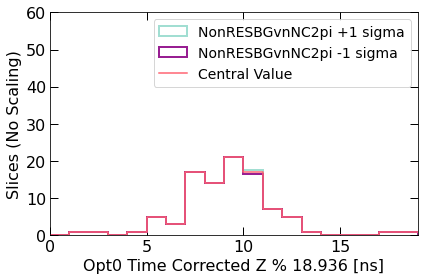

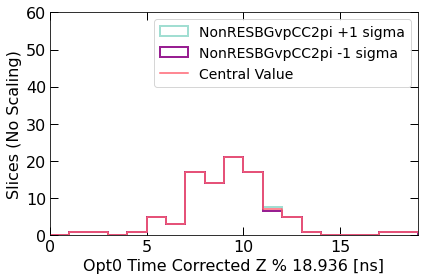

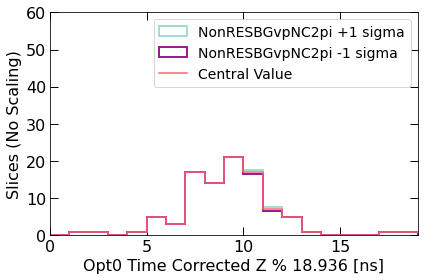

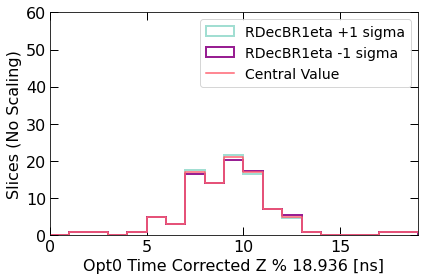

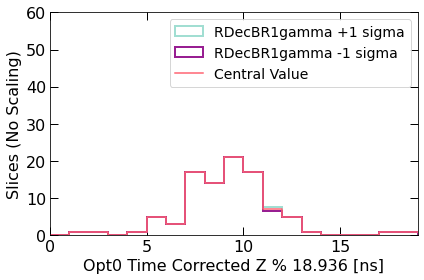

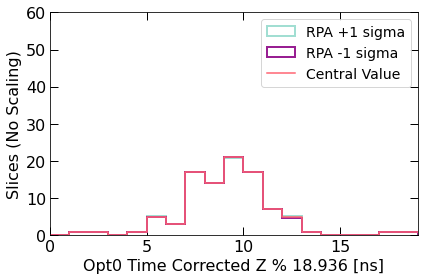

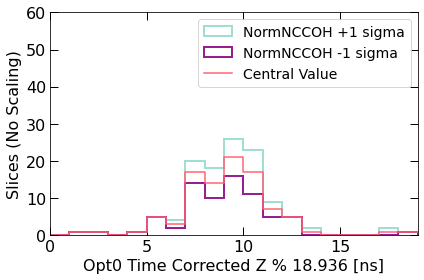

In [45]:
nu_multisigma_pos1_arr = []
nu_multisigma_neg1_arr = []
    
for name in multisigma_list:
    
    #check if weight contains anything other than 1
    pos1_reweight = all(p == 1 for p in df_nu[name+"_pos1"])
    neg1_reweight = all(p == 1 for p in df_nu[name+"_neg1"])

    
    if ( (pos1_reweight == False) or (neg1_reweight == False)):

        fig, ax = plt.subplots(1,1, figsize = (6,4))

        xmin, xmax, xnbin = xmin, xmax, xnbin
        xlimmin, xlimmax = xmin, xmax
        #-----------------------------------------------------------------#
        pltdf = df_nu['mod_t']
        
        #-----------------------------------------------------------------#
        weights = df_nu[name+"_pos1"]
        label = name.split("_")[3]
    
        nu_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["PastelGreen"],
                            #alpha = 0.2,
                            linestyle = "-",
                            linewidth = 2,
                            label = label +" +1 sigma"
                        )
        nu_multisigma_pos1_arr.append(nu_n)
        #-----------------------------------------------------------------#
        #for name in multisigma_list:
        weights = df_nu[name+"_neg1"]
        label = name.split("_")[3]
    
        nu_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["Purple"],
                            #alpha = 0.2,
                            linestyle = "-",
                            linewidth = 2,
                            label = label +" -1 sigma"
                        )
        nu_multisigma_neg1_arr.append(nu_n)
        #-----------------------------------------------------------------#
        #central value
        ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")

        #-----------------------------------------------------------------#

        ax.legend(loc = 'best',fontsize = 14)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol =2)

        plot_tick(ax, 16)
        plot_title(ax, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

        ax.set_xlim(xmin, xmax)
        ax.set_ylim(nu_ymin, nu_ymax)
        #-----------------------------------------------------------------#
        fig.tight_layout()

        if ifSave:
            plt.savefig(savePath+str("nu_beam_bucket_multisigma_xsec_weight_universe"+name+".png"), dpi=200)
        plt.show()

In [46]:
nu_multisigma_neg1_sort_arr = []
nu_multisigma_pos1_sort_arr = []

for neg,pos in zip(nu_multisigma_neg1_arr, nu_multisigma_pos1_arr):

    neg_arr = []
    pos_arr = []
    
    for negItem, posItem in zip(neg, pos):
        neg_arr.append(min(negItem, posItem))
        pos_arr.append(max(negItem, posItem))
        
    nu_multisigma_neg1_sort_arr.append(neg_arr)
    nu_multisigma_pos1_sort_arr.append(pos_arr)

#print(nu_multisigma_neg1_sort_arr)
for neg,pos in zip(nu_multisigma_neg1_sort_arr, nu_multisigma_pos1_sort_arr):
    print()
    print(neg)
    print(pos)


[0.0, 1.0, 1.0, 0.0, 1.0, 4.998382568359375, 3.0, 17.0, 14.0, 20.997467041015625, 17.0, 6.9971771240234375, 4.991546630859375, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]
[0.0, 1.0, 1.0, 0.0, 1.0, 5.001614570617676, 3.0, 17.0, 14.0, 21.002521514892578, 17.0, 7.002799987792969, 5.008476257324219, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]

[0.0, 1.0, 0.5, 0.0, 1.0, 5.0, 3.0, 16.5, 14.0, 21.0, 17.0, 7.0, 5.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]
[0.0, 1.0, 1.5, 0.0, 1.0, 5.0, 3.0, 17.5, 14.0, 21.0, 17.0, 7.0, 5.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]

[0.0, 1.0, 1.0, 0.0, 0.5, 5.0, 3.0, 17.0, 13.0, 20.0, 16.5, 7.0, 5.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]
[0.0, 1.0, 1.0, 0.0, 1.5, 5.0, 3.0, 17.0, 15.0, 22.0, 17.5, 7.0, 5.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]

[0.0, 1.0, 1.0, 0.0, 1.0, 5.0, 3.0, 17.0, 14.0, 21.0, 16.5, 7.0, 5.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]
[0.0, 1.0, 1.0, 0.0, 1.0, 5.0, 3.0, 17.0, 14.0, 21.0, 17.5, 7.0, 5.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]

[0.0, 1.0, 1.0, 0.0, 1.0, 5.0, 3.0, 17.0, 14.0, 21.0, 17.0, 6.5, 5.0, 1.0, 0.0, 0.

In [47]:
#Negative
nu_multisigma_neg1_err = abs(nu_dict['nu_cv'] - nu_multisigma_neg1_sort_arr)

#Positve
nu_multisigma_pos1_err = abs(nu_dict['nu_cv'] - nu_multisigma_pos1_sort_arr)

In [48]:
nu_dict['neg_xsec_multisigma'] = nu_multisigma_neg1_err
nu_dict['pos_xsec_multisigma'] = nu_multisigma_pos1_err

for i in range(0, 4):
    print(i)
    print(nu_dict['neg_xsec_multisigma'][i])
    print(nu_dict['pos_xsec_multisigma'][i])

0
[0.         0.         0.         0.         0.         0.00161743
 0.         0.         0.         0.00253296 0.         0.00282288
 0.00845337 0.         0.         0.         0.         0.
 0.        ]
[0.         0.         0.         0.         0.         0.00161457
 0.         0.         0.         0.00252151 0.         0.00279999
 0.00847626 0.         0.         0.         0.         0.
 0.        ]
1
[0.  0.  0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0. ]
[0.  0.  0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0. ]
2
[0.  0.  0.  0.  0.5 0.  0.  0.  1.  1.  0.5 0.  0.  0.  0.  0.  0.  0.
 0. ]
[0.  0.  0.  0.  0.5 0.  0.  0.  1.  1.  0.5 0.  0.  0.  0.  0.  0.  0.
 0. ]
3
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.
 0. ]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.
 0. ]


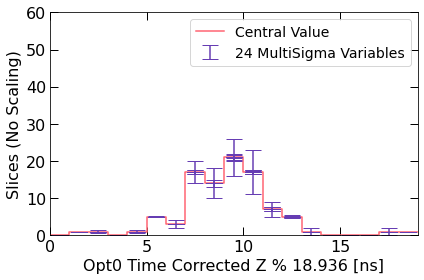

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

#-----------------------------------------------------------------#

#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#

#universe 1 sigma
for i in range(0, nu_multisigma_neg1_err.shape[0]):
    label = ""
    if i == 0:
        label = '24 MultiSigma Variables'
    ax.errorbar(bins_mid
                , nu_dict['nu_cv']
                , [nu_dict['neg_xsec_multisigma'][i],nu_dict['pos_xsec_multisigma'][i]]
                , ls='none'
                , color = col_dict['Mauve']
                , capsize=8
                , label = label
               )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()
if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_weight_multisigma_1sigband.png"), dpi=200)
plt.show()

<h3>Multi Sigma - TODO: Throw Universe Using TSpline and Construct Covariance Matrix</h3>

<h3>Multi Sim</h3>

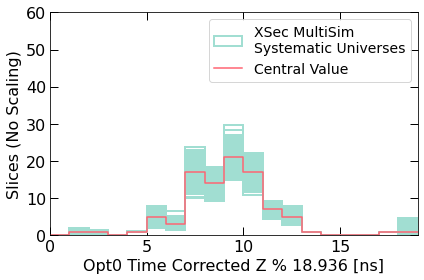

In [50]:
nu_xsec_multisim_universe = []

fig, ax = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#-----------------------------------------------------------------#
#Universe
pltdf = df_nu['mod_t']

for i in range(0, 500):
    weights = df_nu['xsecw_{}'.format(i)]
    label = ''
    if i == 0:
        label = "XSec MultiSim \nSystematic Universes"
        
    nu_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["PastelGreen"],
                            linestyle = "-",
                            linewidth = 2,
                            label = label
                        )
    nu_xsec_multisim_universe.append(nu_n)
    
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")

#-----------------------------------------------------------------#
ax.legend(loc = 'upper right',fontsize = 14)

plot_tick(ax, 16)
plot_title(ax, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_multisim_weight_universe.png"), dpi=200)
plt.show()

In [51]:
nu_xsec_multisim_universe = np.array(nu_xsec_multisim_universe)
nu_xsec_multisim_universe = np.sort(nu_xsec_multisim_universe, axis = 0)

nu_xsec_multisim_median, nu_xsec_multisim_err = get_median_68_quantile(nu_dict['nu_cv'], nu_xsec_multisim_universe)

#make array for plotting
nu_xsec_multisim_median_plot = np.insert(nu_xsec_multisim_median, 0, 0)

CV array
[ 0.  1.  1.  0.  1.  5.  3. 17. 14. 21. 17.  7.  5.  1.  0.  0.  0.  1.
  1.]
Weight array shape
(500, 19)

 Median
[ 0.          0.90485835  0.99760023  0.          0.99927193  4.82552791
  2.91544294 16.6262207  13.67295456 21.04311371 16.58794022  6.86711502
  4.84202957  1.          0.          0.          0.          1.
  0.81157684]

 Low 34.1 quantile
[ 0.          0.62125324  0.76310864  0.          0.9723512   3.8560753
  2.18416704 14.2470382  12.17899112 19.0432458  14.76010389  6.074163
  4.05178144  1.          0.          0.          0.          1.
  0.36985984]

 High 34.1 quantile
[ 0.          1.29376672  1.18411185  0.          1.01630535  5.70943501
  3.78345273 19.07881817 15.42795028 23.27864813 18.86527362  7.85727241
  5.72889308  1.          0.          0.          0.          1.
  1.61141626]

 Standard Error
[[0.         0.37874676 0.23689136 0.         0.0276488  1.1439247
  0.81583296 2.7529618  1.82100888 1.9567542  2.23989611 0.925837
  0.9482185

In [52]:
nu_dict['neg_xsec_multisim'] = nu_xsec_multisim_err[0]
nu_dict['pos_xsec_multisim'] = nu_xsec_multisim_err[1]
nu_dict

{'nu_cv': array([ 0.,  1.,  1.,  0.,  1.,  5.,  3., 17., 14., 21., 17.,  7.,  5.,
         1.,  0.,  0.,  0.,  1.,  1.]),
 'nu_cv_plot': array([ 0.,  0.,  1.,  1.,  0.,  1.,  5.,  3., 17., 14., 21., 17.,  7.,
         5.,  1.,  0.,  0.,  0.,  1.,  1.]),
 'bins': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 'bins_mid': array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 'neg_stat_err': array([0.        , 1.        , 1.        , 0.        , 1.        ,
        2.23606798, 1.73205081, 4.12310563, 3.74165739, 4.58257569,
        4.12310563, 2.64575131, 2.23606798, 1.        , 0.        ,
        0.        , 0.        , 1.        , 1.        ]),
 'pos_stat_err': array([0.        , 1.        , 1.        , 0.        , 1.        ,
        2.23606798, 1.73205081, 4.12310563, 3.74165739, 4.58257569,
        4.12310563, 2.64575131, 2.23606798, 1.

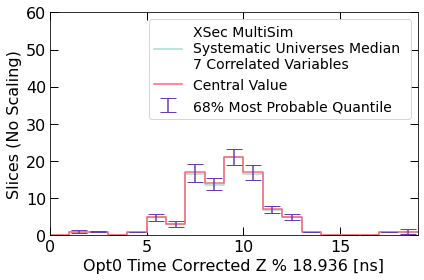

In [53]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#median
ax.step(bins, nu_xsec_multisim_median_plot, color = col_dict['PastelGreen'], label = "XSec MultiSim \nSystematic Universes Median \n7 Correlated Variables")
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , nu_xsec_multisim_err
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            ,label = "68% Most Probable Quantile"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_multisim_weight_median68.png"), dpi=200)
plt.show()

<h3>Covarariance Matrix</h3>

In [54]:
nu_xsec_multisim_cov, _ = get_cov_corr_matrix(nu_dict['nu_cv'], nu_xsec_multisim_universe)

(19,)
(500, 19)


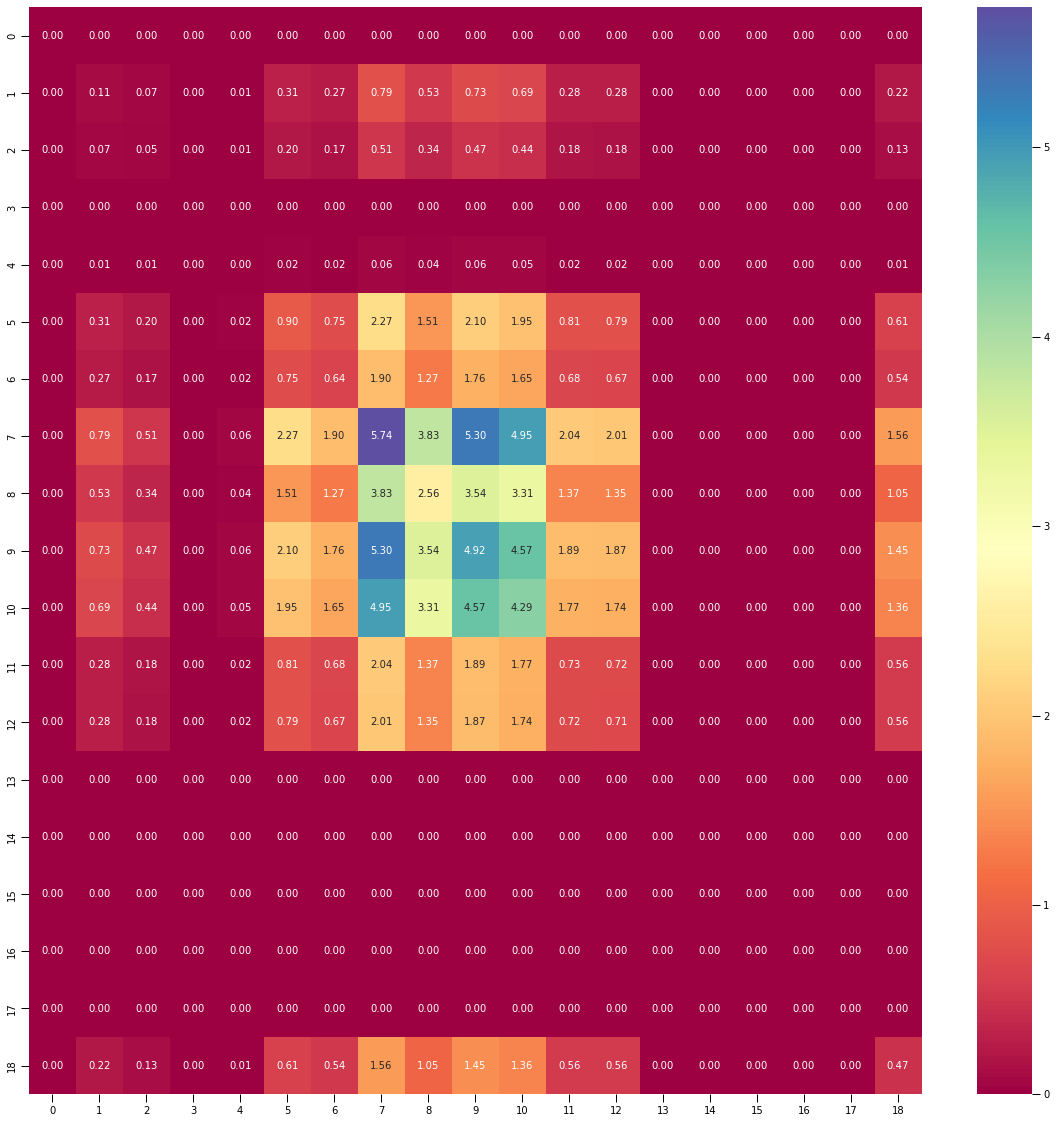

In [55]:
fig, ax = plt.subplots(1,1, figsize = (20, 20))

ax = sns.heatmap(nu_xsec_multisim_cov, annot=True, fmt='.2f', cmap = "Spectral")
plt.show()

In [56]:
nu_dict['cov_xsec_multisim_err'] = np.sqrt(np.diag(nu_xsec_multisim_cov))

<h3>Comparison</h3>

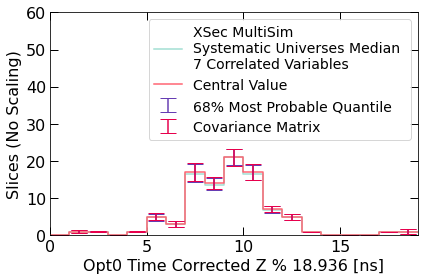

In [57]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#median
ax.step(bins, nu_xsec_multisim_median_plot, color = col_dict['PastelGreen'], label = "XSec MultiSim \nSystematic Universes Median \n7 Correlated Variables")
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , nu_xsec_multisim_err
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            ,label = "68% Most Probable Quantile"
           )
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , nu_dict['cov_xsec_multisim_err']
            , ls='none'
            , color = col_dict['Coral']
            , capsize=8
            ,label = "Covariance Matrix"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_multisim_weight_median68.png"), dpi=200)
plt.show()

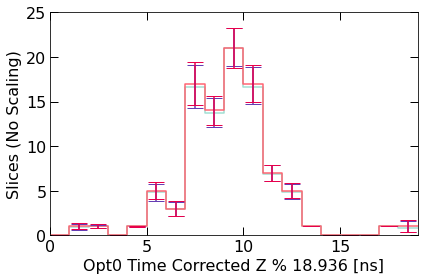

In [181]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#median
ax.step(bins, nu_xsec_multisim_median_plot, color = col_dict['PastelGreen'], label = "XSec MultiSim \nSystematic Universes Median \n7 Correlated Variables")
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , nu_xsec_multisim_err
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            ,label = "68% Most Probable Quantile"
           )
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , nu_dict['cov_xsec_multisim_err']
            , ls='none'
            , color = col_dict['Coral']
            , capsize=8
            ,label = "Covariance Matrix"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax, 16)

#ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, 25)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_multisim_weight_median68.png"), dpi=200)
plt.show()

<h3> Quadrature Sum All Xsec Systematics </h3>

In [58]:
# function to calculate the sum of an array
def quadratureSumArray(arr):
    quadSum = 0
    
    for element in arr: 
        quadSum = quadSum + element**2
        
    return np.sqrt(quadSum)

In [59]:
#Negative
nu_dict['neg_xsec_multisim'] = nu_dict['neg_xsec_multisim'].reshape(1,19)

nu_xsec_neg = np.append(nu_dict['neg_xsec_multisim'], nu_dict['neg_xsec_multisigma'], axis=0)
print(nu_xsec_neg.shape)
#print(nu_xsec_neg)

nu_xsec_neg_quadSum = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_xsec_neg)

print(nu_xsec_neg_quadSum.shape)
print(nu_xsec_neg_quadSum)

nu_dict['neg_xsec_quadSum'] = nu_xsec_neg_quadSum


(11, 19)
(19,)
[0.         0.37875879 0.55327888 0.         0.50076387 1.15183107
 1.29059031 4.1327605  4.50736145 5.5037139  6.47525362 2.36760152
 1.04684238 1.         0.         0.         0.         1.
 0.63014037]


In [60]:
#Positive
nu_dict['pos_xsec_multisim'] = nu_dict['pos_xsec_multisim'].reshape(1,19)

nu_xsec_pos = np.append(nu_dict['pos_xsec_multisim'], nu_dict['pos_xsec_multisigma'], axis=0)
print(nu_xsec_pos.shape)
#print(nu_xsec_neg)

nu_xsec_pos_quadSum = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_xsec_pos)

print(nu_xsec_pos_quadSum.shape)
print(nu_xsec_pos_quadSum)

nu_dict['pos_xsec_quadSum'] = nu_xsec_pos_quadSum


(11, 19)
(19,)
[0.         0.29378223 0.53282002 0.         0.50026579 0.72211444
 1.27036928 3.71784823 4.36340188 5.62620804 6.35539303 2.34164016
 0.85325614 1.         0.         0.         0.         1.
 0.61141647]


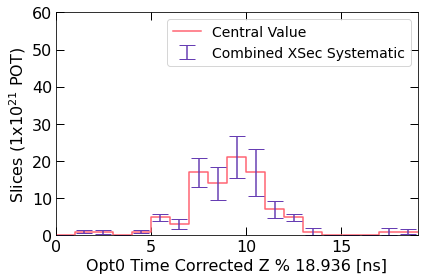

In [61]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_xsec_quadSum'], nu_dict['pos_xsec_quadSum']],
            ls='none',
            color = col_dict['Mauve'],
            capsize=8
            ,label = "Combined XSec Systematic"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (1x10$^{21}$ POT)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_weight_combined.png"), dpi=200)
plt.show()

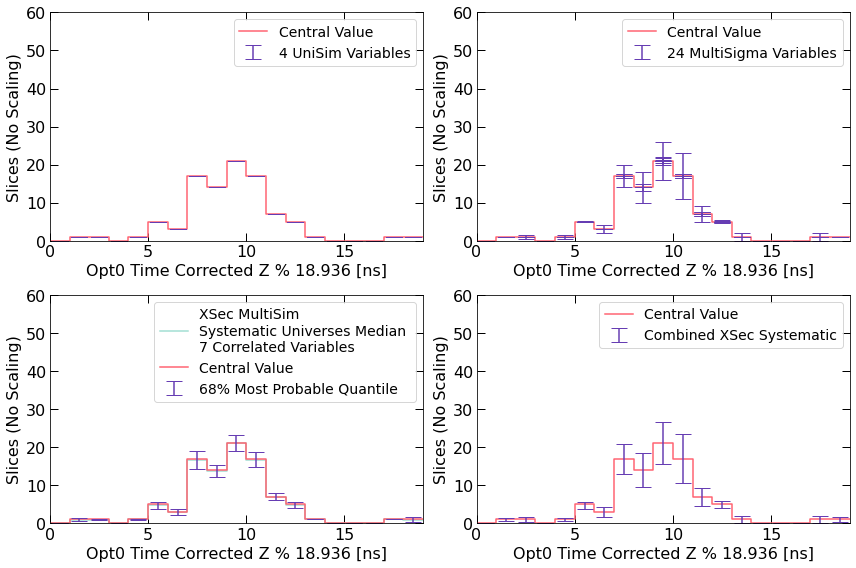

In [62]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (12,8))#, sharex = True, sharey = True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#========================================================================#
#UNISIM
#central value
ax1.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#TODO: CURRENTLY PLOTTING 
#universe 1 sigma
for i in range(0, nu_unisim_err.shape[0]):
    label = ""
    if i == 0:
        label = '4 UniSim Variables'
    ax1.errorbar(bins_mid, nu_dict['nu_cv']
                , yerr=(np.maximum(0, - nu_unisim_err[i]), np.maximum(0, nu_unisim_err[i]))
                , ls='none'
                , color = col_dict['Mauve']
                , capsize=8
                , label = label
                )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax1,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax1, 16)

ax1.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(nu_ymin, nu_ymax)

#========================================================================#
#MULTISIGMA
#central value
ax2.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#

#universe 1 sigma
for i in range(0, nu_multisigma_neg1_err.shape[0]):
    label = ""
    if i == 0:
        label = '24 MultiSigma Variables'
    ax2.errorbar(bins_mid
                , nu_dict['nu_cv']
                , [nu_dict['neg_xsec_multisigma'][i],nu_dict['pos_xsec_multisigma'][i]]
                , ls='none'
                , color = col_dict['Mauve']
                , capsize=8
                , label = label
               )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax2,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax2, 16)

ax2.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax2.set_xlim(xmin, xmax)
ax2.set_ylim(nu_ymin, nu_ymax)

#========================================================================#
#MULTISIM
#median
ax3.step(bins, nu_xsec_multisim_median_plot, color = col_dict['PastelGreen'], label = "XSec MultiSim \nSystematic Universes Median \n7 Correlated Variables")
#-----------------------------------------------------------------#
#central value
ax3.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax3.errorbar(bins_mid, nu_dict['nu_cv']
            , nu_xsec_multisim_err
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            ,label = "68% Most Probable Quantile"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax3,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax3, 16)

ax3.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax3.set_xlim(xmin, xmax)
ax3.set_ylim(nu_ymin, nu_ymax)

#========================================================================#
#COMBINED
#central value
ax4.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax4.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_xsec_quadSum'], nu_dict['pos_xsec_quadSum']],
            ls='none',
            color = col_dict['Mauve'],
            capsize=8
            ,label = "Combined XSec Systematic"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax4,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax4, 16)

ax4.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax4.set_xlim(xmin, xmax)
ax4.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_weight_all.png"), dpi=200)
plt.show()

<h1>Geant4 ReInteractions Weights</h1>

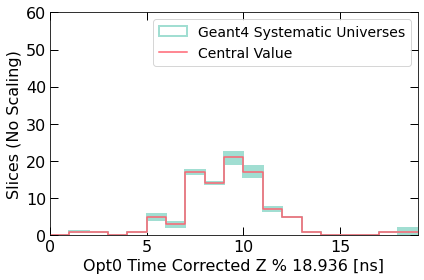

In [63]:
nu_g4_multisim_universe = []

fig, ax = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#-----------------------------------------------------------------#
pltdf = df_nu['mod_t']

for i in range(0, 1000):
    weights = df_nu['g4w_{}'.format(i)]
    label = ''
    if i == 0:
        label = "Geant4 Systematic Universes"
        
    nu_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["PastelGreen"],
                            linestyle = "-",
                            linewidth = 2,
                            label = label
                        )
    nu_g4_multisim_universe.append(nu_n)
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
ax.legend(loc = 'upper right',fontsize = 14)

plot_tick(ax, 16)
plot_title(ax, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_g4_multisim_weight_universe.png"), dpi=200)
plt.show()

In [64]:
nu_g4_multisim_universe = np.array(nu_g4_multisim_universe)
nu_g4_multisim_universe = np.sort(nu_g4_multisim_universe, axis = 0)

nu_g4_multisim_median, nu_g4_multisim_err = get_median_68_quantile(nu_dict['nu_cv'], nu_g4_multisim_universe)

#make array for plotting
nu_g4_multisim_median_plot = np.insert(nu_g4_multisim_median, 0, 0)

CV array
[ 0.  1.  1.  0.  1.  5.  3. 17. 14. 21. 17.  7.  5.  1.  0.  0.  0.  1.
  1.]
Weight array shape
(1000, 19)

 Median
[ 0.          0.99961266  0.99998233  0.          1.          4.98492551
  2.99217176 17.00927544 13.99787903 20.95938683 17.0231514   7.01876831
  4.99981308  1.          0.          0.          0.          1.
  0.9570694 ]

 Low 34.1 quantile
[ 0.          0.98527939  0.99950986  0.          1.          4.7649772
  2.79696793 16.85855423 13.90269458 20.55943243 16.52987038  6.84967709
  4.99326387  1.          0.          0.          0.          1.
  0.73434066]

 High 34.1 quantile
[ 0.          1.01455272  1.00047944  0.          1.          5.23572809
  3.17313978 17.15662669 14.09828784 21.3939862  17.50047541  7.18570933
  5.00658326  1.          0.          0.          0.          1.
  1.22042469]

 Standard Error
[[0.00000000e+00 1.47206128e-02 4.90143138e-04 0.00000000e+00
  0.00000000e+00 2.35022804e-01 2.03032073e-01 1.41445771e-01
  9.73054186e-02 

In [65]:
nu_dict['neg_g4_err'] = nu_g4_multisim_err[0]
nu_dict['pos_g4_err'] = nu_g4_multisim_err[1]
nu_dict.keys()

dict_keys(['nu_cv', 'nu_cv_plot', 'bins', 'bins_mid', 'neg_stat_err', 'pos_stat_err', 'neg_flx_err', 'pos_flx_err', 'cov_flx_err', 'neg_xsec_multisigma', 'pos_xsec_multisigma', 'neg_xsec_multisim', 'pos_xsec_multisim', 'cov_xsec_multisim_err', 'neg_xsec_quadSum', 'pos_xsec_quadSum', 'neg_g4_err', 'pos_g4_err'])

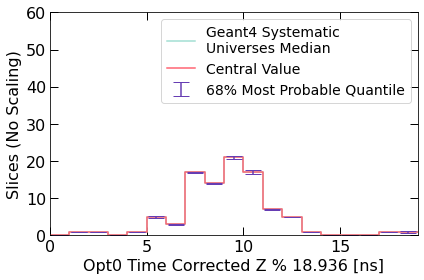

In [66]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#median
ax.step(bins, nu_g4_multisim_median_plot , color = col_dict['PastelGreen'], label = "Geant4 Systematic \nUniverses Median")
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_g4_err'], nu_dict['pos_g4_err']]
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            , label = "68% Most Probable Quantile"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_g4_multisim_weight_median68.png"), dpi=200)
plt.show()

<h3>Covariance Matrix</h3>

In [67]:
nu_g4_multisim_cov, _ = get_cov_corr_matrix(nu_dict['nu_cv'], nu_g4_multisim_universe)

(19,)
(1000, 19)


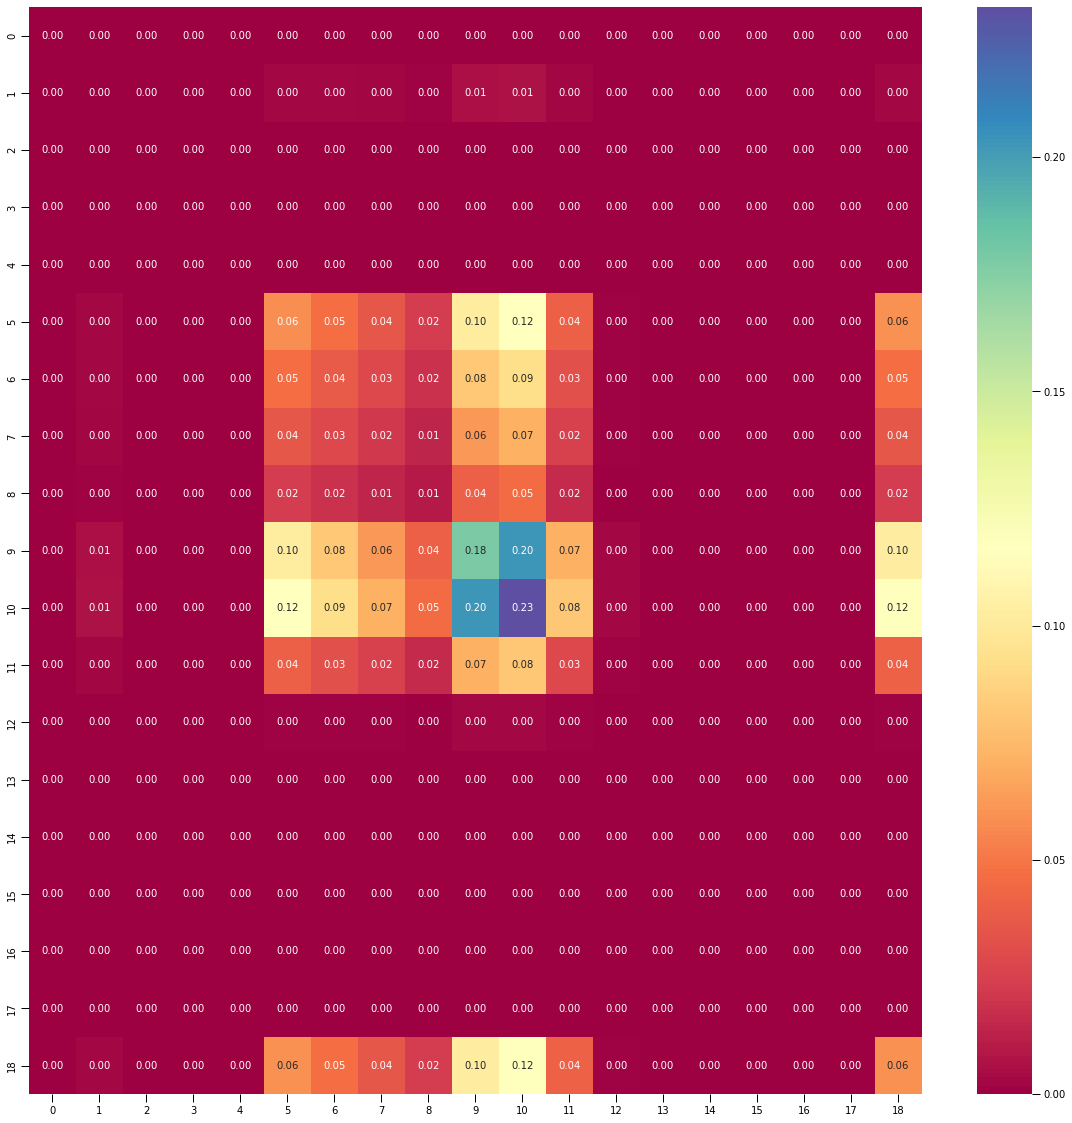

In [68]:
fig, ax = plt.subplots(1,1, figsize = (20, 20))

ax = sns.heatmap(nu_g4_multisim_cov, annot=True, fmt='.2f', cmap = "Spectral")
plt.show()

In [69]:
nu_dict['cov_g4_multisim_err'] = np.sqrt(np.diag(nu_g4_multisim_cov))

<h3>Comparison</h3>

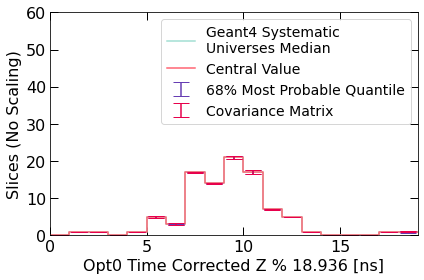

In [70]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#median
ax.step(bins, nu_g4_multisim_median_plot , color = col_dict['PastelGreen'], label = "Geant4 Systematic \nUniverses Median")
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_g4_err'], nu_dict['pos_g4_err']]
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            , label = "68% Most Probable Quantile"
           )
#-----------------------------------------------------------------#
#covariance matrix
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['cov_g4_multisim_err'], nu_dict['cov_g4_multisim_err']]
            , ls='none'
            , color = col_dict['Coral']
            , capsize=8
            , label = "Covariance Matrix"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (No Scaling)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_g4_multisim_weight_median68.png"), dpi=200)
plt.show()

<h1>Plot Everything</h1>

<h2>HNL - Directly Sum 1 Sigma </h2>

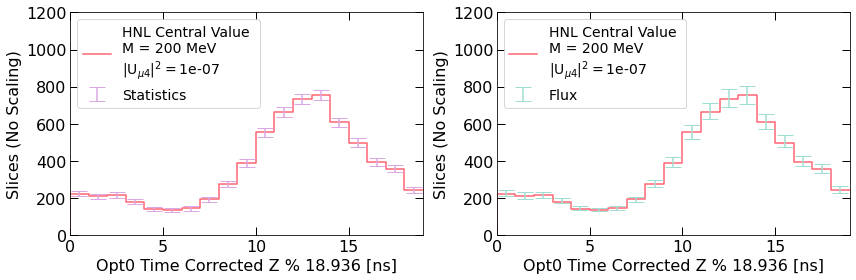

In [71]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))#, sharex = True, sharey = True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#=========================================================================#
#STATS
ax1.step(bins, hnl_dict['hnl_cv_plot'], color = col_dict['Flamingo']
         , label =  "HNL Central Value \nM = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(simU))
        )

ax1.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_stat_err'],hnl_dict['pos_stat_err']]
            , ls='none'
            , color = col_dict['Lavender']
            , capsize=8
            , label = "Statistics"
           )
#-----------------------------------------------------------------#
ax1.legend(loc = 'upper left',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(hnl_ymin, hnl_ymax)

#=========================================================================#
#FLUX
#-----------------------------------------------------------------#
#central value
ax2.step(bins, hnl_dict['hnl_cv_plot'], color = col_dict['Flamingo']
         , label =  "HNL Central Value \nM = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(simU)))
#-----------------------------------------------------------------#
#universe 1 sigma
ax2.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_flx_err'],hnl_dict['pos_flx_err']]
            , ls='none'
            , color = col_dict['PastelGreen']
            , capsize=8
            ,label = "Flux"
           )

#-----------------------------------------------------------------#
ax2.legend(loc = 'upper left',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax2.set_xlim(xmin, xmax)
ax2.set_ylim(hnl_ymin, hnl_ymax)

#=========================================================================#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_standard_error.png"), dpi=200)
    
plt.show()

In [72]:
hnl_dict['neg_stat_err'] = hnl_dict['neg_stat_err'].reshape(1,19)
hnl_dict['neg_flx_err'] = hnl_dict['neg_flx_err'].reshape(1,19)

hnl_neg_err = np.append(hnl_dict['neg_stat_err']
                        , hnl_dict['neg_flx_err']
                        , axis=0)

hnl_neg_quad_err = np.apply_along_axis(quadratureSumArray, axis=0, arr=hnl_neg_err)

hnl_dict['neg_quadSum_err'] = hnl_neg_quad_err
#------------------------------------------------------------------#

hnl_dict['pos_flx_err'] = hnl_dict['pos_flx_err'].reshape(1,19)
hnl_dict['pos_stat_err'] = hnl_dict['pos_stat_err'].reshape(1,19)

hnl_pos_err = np.append(hnl_dict['pos_stat_err']
                        , hnl_dict['pos_flx_err']
                        , axis=0)

hnl_pos_quad_err = np.apply_along_axis(quadratureSumArray, axis=0, arr=hnl_pos_err)

hnl_dict['pos_quadSum_err'] = hnl_pos_quad_err
#------------------------------------------------------------------#
print("\n Negative Direction")
print(hnl_neg_err)
print(hnl_neg_quad_err)

#------------------------------------------------------------------#
print("\n Positive Direction")
print(hnl_pos_err)
print(hnl_pos_quad_err)


 Negative Direction
[[15.         14.49137675 14.69693846 13.45362405 11.91637529 11.66190379
  12.04159458 13.89244399 16.673332   19.74841766 23.55843798 25.78759392
  27.11088342 27.49545417 24.65765601 22.3383079  19.87460691 18.89444363
  15.62049935]
 [14.82236181 11.89523446 13.05976639  9.47962073  7.62156736  5.62750055
   7.72958216 13.17855111 16.93581966 23.92766689 35.5655073  40.5532641
  45.51718412 47.54054163 34.93808537 26.28717006 21.32981642 20.85261601
  13.80900224]]
[21.08796836 18.74824266 19.66106554 16.45792239 14.14525677 12.94869733
 14.30896364 19.14873911 23.76598384 31.02471987 42.66034821 48.05795698
 52.97937382 54.91905951 42.76294903 34.49659852 29.15409179 28.13950238
 20.84918567]

 Positive Direction
[[15.         14.49137675 14.69693846 13.45362405 11.91637529 11.66190379
  12.04159458 13.89244399 16.673332   19.74841766 23.55843798 25.78759392
  27.11088342 27.49545417 24.65765601 22.3383079  19.87460691 18.89444363
  15.62049935]
 [16.81393034 

In [73]:
#FOR PLOTTING

#Stat
hnl_stat_neg_diff = hnl_dict['neg_stat_err'] / hnl_dict['hnl_cv']
hnl_stat_neg_diff = np.insert(hnl_stat_neg_diff, 0, 0)

hnl_stat_pos_diff = hnl_dict['pos_stat_err'] / hnl_dict['hnl_cv']
hnl_stat_pos_diff = np.insert(hnl_stat_pos_diff, 0, 0)

#Flux
hnl_flx_neg_diff = hnl_dict['neg_flx_err'] / hnl_dict['hnl_cv']
hnl_flx_neg_diff = np.insert(hnl_flx_neg_diff, 0, 0)

hnl_flx_pos_diff = hnl_dict['pos_flx_err'] / hnl_dict['hnl_cv']
hnl_flx_pos_diff = np.insert(hnl_flx_pos_diff, 0, 0)

#Quad Sum
hnl_quadsum_neg_diff = hnl_dict['neg_quadSum_err'] / hnl_dict['hnl_cv']
hnl_quadsum_neg_diff = np.insert(hnl_quadsum_neg_diff, 0, 0)

hnl_quadsum_pos_diff = hnl_dict['pos_quadSum_err'] / hnl_dict['hnl_cv']
hnl_quadsum_pos_diff = np.insert(hnl_quadsum_pos_diff, 0, 0)

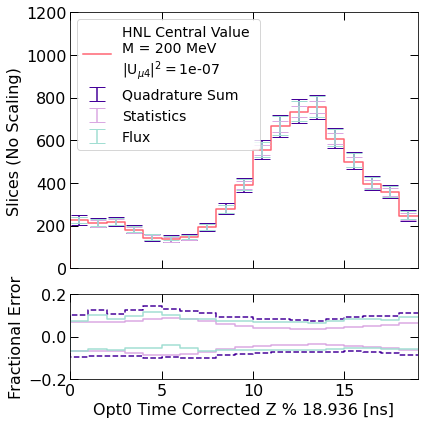

In [74]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize = (6, 6), sharex = True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#=========================================================================#

ax1.step(bins, hnl_dict['hnl_cv_plot'], color = col_dict['Flamingo']
         , label =  "HNL Central Value \nM = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(simU))
        )
#-----------------------------------------------------------------#
#QuadSum
ax1.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_quadSum_err'], hnl_dict['pos_quadSum_err']]
            , ls='none'
            , color = col_dict['DeepViolet']
            , capsize=8
            ,label = "Quadrature Sum"
           )
#-----------------------------------------------------------------#
#STATS
ax1.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_stat_err'].flatten(), hnl_dict['pos_stat_err'].flatten()]
            , ls='none'
            , color = col_dict['Lavender']
            , capsize=8
            ,label = "Statistics"
           )
#-----------------------------------------------------------------#
#Flux
ax1.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_flx_err'].flatten(), hnl_dict['pos_flx_err'].flatten()]
            , ls='none'
            , color = col_dict['PastelGreen']
            , capsize=8
            ,label = "Flux"
           )
#-----------------------------------------------------------------#
ax1.legend(loc = 'upper left',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", '',  "Slices (No Scaling)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(hnl_ymin, hnl_ymax)
#=========================================================================#
#-----------------------------------------------------------------#
#QuadSum
ax2.step(bins, hnl_quadsum_neg_diff  * -1
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )

ax2.step(bins, hnl_quadsum_pos_diff
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )
#-----------------------------------------------------------------#
#STATS
ax2.step(bins, hnl_stat_neg_diff  * -1
         , color = col_dict['Lavender']
        )

ax2.step(bins, hnl_stat_pos_diff
         , color = col_dict['Lavender']
        )
#-----------------------------------------------------------------#
#Flux
ax2.step(bins, hnl_flx_neg_diff  * -1
         , color = col_dict['PastelGreen']
        )

ax2.step(bins, hnl_flx_pos_diff
         , color = col_dict['PastelGreen']
        )

#-----------------------------------------------------------------#

#ax2.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Fractional Error", 16)


ax2.set_xlim(xmin, xmax)
ax2.set_ylim(-0.2, 0.2)
#=========================================================================#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_combined_standard_error.png"), dpi=200)
    
plt.show()

<h3>Scale To POT AND Umu Coupling</h3>

In [75]:
scale_factor = df_hnl['scale_pot'].unique()[0]
fitU = plotU
print(scale_factor)
print(fitU)


scale = 1/80
scale_factor = scale_factor * scale
fitU = getUfromScaleFactor(fitU, scale)
print(scale_factor)
print(fitU)


4.748902766684984
8.944271909999158e-07
0.0593612845835623
1e-07


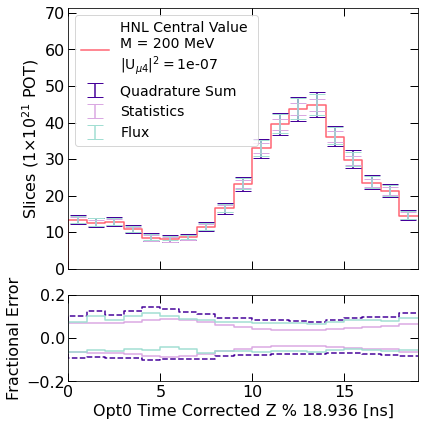

In [76]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize = (6, 6), sharex = True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#=========================================================================#

ax1.step(bins, hnl_dict['hnl_cv_plot']* scale_factor
         , color = col_dict['Flamingo']
         , label =  "HNL Central Value \nM = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(fitU))
        )
#-----------------------------------------------------------------#
#QuadSum
ax1.errorbar(bins_mid, hnl_dict['hnl_cv'] * scale_factor
            , [hnl_quadsum_neg_diff[1:] * hnl_dict['hnl_cv'] * scale_factor
               , hnl_quadsum_pos_diff[1:] * hnl_dict['hnl_cv'] * scale_factor]
            , ls='none'
            , color = col_dict['DeepViolet']
            , capsize=8
            ,label = "Quadrature Sum"
           )
#-----------------------------------------------------------------#
#STATS
ax1.errorbar(bins_mid, hnl_dict['hnl_cv'] * scale_factor
            , [hnl_stat_neg_diff[1:] * hnl_dict['hnl_cv'] * scale_factor
               , hnl_stat_pos_diff[1:] * hnl_dict['hnl_cv'] * scale_factor]
            , ls='none'
            , color = col_dict['Lavender']
            , capsize=8
            ,label = "Statistics"
           )
#-----------------------------------------------------------------#
#Flux
ax1.errorbar(bins_mid, hnl_dict['hnl_cv'] * scale_factor
            , [hnl_flx_neg_diff[1:] * hnl_dict['hnl_cv'] * scale_factor
               , hnl_flx_pos_diff[1:] * hnl_dict['hnl_cv'] * scale_factor]
            , ls='none'
            , color = col_dict['PastelGreen']
            , capsize=8
            ,label = "Flux"
           )
#-----------------------------------------------------------------#
ax1.legend(loc = 'upper left',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", '',  r"Slices (1$\times10^{21}$ POT)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(hnl_ymin, hnl_ymax * scale_factor)
#=========================================================================#
#-----------------------------------------------------------------#
#QuadSum
ax2.step(bins, hnl_quadsum_neg_diff * -1
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )

ax2.step(bins, hnl_quadsum_pos_diff
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )
#-----------------------------------------------------------------#
#STATS
ax2.step(bins, hnl_stat_neg_diff   * -1
         , color = col_dict['Lavender']
        )

ax2.step(bins, hnl_stat_pos_diff
         , color = col_dict['Lavender']
        )
#-----------------------------------------------------------------#
#Flux
ax2.step(bins, hnl_flx_neg_diff * -1
         , color = col_dict['PastelGreen']
        )

ax2.step(bins, hnl_flx_pos_diff
         , color = col_dict['PastelGreen']
        )

#-----------------------------------------------------------------#

#ax2.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Fractional Error", 16)


ax2.set_xlim(xmin, xmax)
ax2.set_ylim(-0.2, 0.2)
#=========================================================================#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_combined_standard_error_scaleToPOT.png"), dpi=200)
    
plt.show()

In [77]:
hnl_dict['hnl_cv_scale'] = hnl_dict['hnl_cv'] * scale_factor

#stat
hnl_dict['neg_stat_err_scale'] = hnl_stat_neg_diff[1:] * hnl_dict['hnl_cv'] * scale_factor
hnl_dict['pos_stat_err_scale'] = hnl_stat_pos_diff[1:] * hnl_dict['hnl_cv'] * scale_factor

#flux
hnl_dict['neg_flx_err_scale'] = hnl_flx_neg_diff[1:] * hnl_dict['hnl_cv'] * scale_factor
hnl_dict['pos_flx_err_scale'] = hnl_flx_pos_diff[1:] * hnl_dict['hnl_cv'] * scale_factor

#quadSum
hnl_dict['neg_quadSum_err_scale'] = hnl_quadsum_neg_diff[1:] * hnl_dict['hnl_cv'] * scale_factor
hnl_dict['pos_quadSum_err_scale'] = hnl_quadsum_pos_diff[1:] * hnl_dict['hnl_cv'] * scale_factor

<h2>HNL - Covariance Matrix Way </h2>

In [78]:
hnl_cv = hnl_dict['hnl_cv']

#stat
hnl_stat_cov = np.diag(hnl_cv) #[some NxN covariance matrix e.g. np.diag(cv) for statistical]
hnl_stat_err = np.sqrt(np.diag(hnl_stat_cov))


hnl_stat_frac = hnl_stat_cov / np.outer(hnl_cv, hnl_cv) # N / (N * N)
hnl_stat_frac_err = np.sqrt(np.diag(hnl_stat_frac)) # sqrt(N)


#flux
hnl_flx_cov, _ = get_cov_corr_matrix(hnl_cv, hnl_flx_universe)
hnl_flx_err = np.sqrt(np.diag(hnl_flx_cov))

hnl_flx_frac = hnl_flx_cov / np.outer(hnl_cv, hnl_cv)
hnl_flx_frac_err = np.sqrt(np.diag(hnl_flx_frac)) # sqrt(N)

#add covariance matrix
hnl_combined_cov = hnl_stat_cov + hnl_flx_cov
hnl_combined_err = np.sqrt(np.diag(hnl_combined_cov))

hnl_combined_frac = hnl_combined_cov / np.outer(hnl_cv, hnl_cv) # N / (N * N)
hnl_combined_frac_err = np.sqrt(np.diag(hnl_combined_frac)) # sqrt(N)

(19,)
(1000, 19)


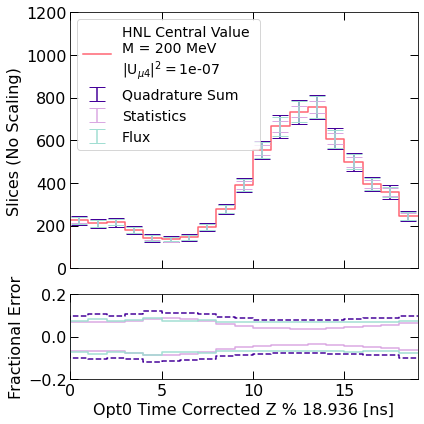

In [79]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize = (6, 6), sharex = True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#=========================================================================#

ax1.step(bins, hnl_dict['hnl_cv_plot']
         , color = col_dict['Flamingo']
         , label =  "HNL Central Value \nM = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(simU))
        )
#-----------------------------------------------------------------#
#Quad Sum
ax1.errorbar(bins_mid, hnl_dict['hnl_cv']
            , hnl_combined_err
            , ls='none'
            , color = col_dict['DeepViolet']
            , capsize=8
            ,label = "Quadrature Sum"
           )
#-----------------------------------------------------------------#
#STATS
ax1.errorbar(bins_mid, hnl_dict['hnl_cv']
            , hnl_stat_err
            , ls='none'
            , color = col_dict['Lavender']
            , capsize=8
            ,label = "Statistics"
           )
#-----------------------------------------------------------------#
#FLUX
ax1.errorbar(bins_mid, hnl_dict['hnl_cv']
            , hnl_flx_err
            , ls='none'
            , color = col_dict['PastelGreen']
            , capsize=8
            ,label = "Flux"
           )


#-----------------------------------------------------------------#
ax1.legend(loc = 'upper left',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", '',  r"Slices (No Scaling)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(hnl_ymin, hnl_ymax)
#=========================================================================#
#-----------------------------------------------------------------#
#QUAD SUM
ax2.step(bins, np.insert(hnl_combined_frac_err, 0,0) * -1
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )

ax2.step(bins, np.insert(hnl_combined_frac_err, 0,0) 
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )
#-----------------------------------------------------------------#
#STATS
ax2.step(bins, np.insert(hnl_stat_frac_err, 0,0) * -1
         , color = col_dict['Lavender']
        )

ax2.step(bins, np.insert(hnl_stat_frac_err, 0,0) 
         , color = col_dict['Lavender']
        )
#-----------------------------------------------------------------#
#FLUX
ax2.step(bins, np.insert(hnl_flx_frac_err, 0,0) * -1
         , color = col_dict['PastelGreen']
        )

ax2.step(bins, np.insert(hnl_flx_frac_err, 0,0) 
         , color = col_dict['PastelGreen']
        )
#-----------------------------------------------------------------#

#ax2.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Fractional Error", 16)


ax2.set_xlim(xmin, xmax)
ax2.set_ylim(-0.2, 0.2)
#=========================================================================#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_combined_covariance.png"), dpi=200)
    
plt.show()

<h3>Scale To POT AND Umu Coupling</h3>

In [80]:
hnl_cv_scale = hnl_cv * scale_factor

#stat
hnl_stat_cov_scale = np.outer(hnl_cv_scale, hnl_cv_scale) * hnl_stat_frac
hnl_stat_err_scale = np.sqrt(np.diag(hnl_stat_cov_scale))

hnl_stat_frac_scale = hnl_stat_cov_scale / np.outer(hnl_cv_scale, hnl_cv_scale) # N / (N * N)
hnl_stat_frac_err_scale = np.sqrt(np.diag(hnl_stat_frac_scale)) # sqrt(N)


#flux
hnl_flx_cov_scale = np.outer(hnl_cv_scale, hnl_cv_scale) * hnl_flx_frac
hnl_flx_err_scale = np.sqrt(np.diag(hnl_flx_cov_scale))

hnl_flx_frac_scale = hnl_flx_cov_scale / np.outer(hnl_cv_scale, hnl_cv_scale)
hnl_flx_frac_err_scale = np.sqrt(np.diag(hnl_flx_frac_scale)) # sqrt(N)


#add covariance matrix
hnl_combined_cov_scale = np.outer(hnl_cv_scale, hnl_cv_scale) * hnl_combined_frac
hnl_combined_err_scale = np.sqrt(np.diag(hnl_combined_cov_scale))

hnl_combined_frac_scale = hnl_combined_cov_scale / np.outer(hnl_cv_scale, hnl_cv_scale) # N / (N * N)
hnl_combined_frac_err_scale = np.sqrt(np.diag(hnl_combined_frac_scale)) # sqrt(N)

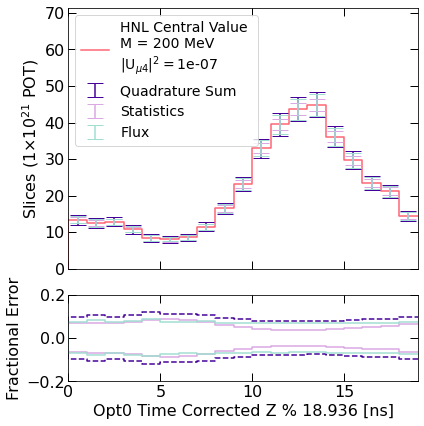

In [81]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize = (6, 6), sharex = True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#=========================================================================#

ax1.step(bins, hnl_dict['hnl_cv_plot'] * scale_factor
         , color = col_dict['Flamingo']
         , label =  "HNL Central Value \nM = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(fitU))
        )
#-----------------------------------------------------------------#
#Quad Sum
ax1.errorbar(bins_mid, hnl_dict['hnl_cv'] * scale_factor
            , hnl_combined_err_scale
            , ls='none'
            , color = col_dict['DeepViolet']
            , capsize=8
            ,label = "Quadrature Sum"
           )
#-----------------------------------------------------------------#
#STATS
ax1.errorbar(bins_mid, hnl_dict['hnl_cv'] * scale_factor
            , hnl_stat_err_scale
            , ls='none'
            , color = col_dict['Lavender']
            , capsize=8
            ,label = "Statistics"
           )
#-----------------------------------------------------------------#
#FLUX
ax1.errorbar(bins_mid, hnl_dict['hnl_cv'] * scale_factor
            , hnl_flx_err_scale
            , ls='none'
            , color = col_dict['PastelGreen']
            , capsize=8
            ,label = "Flux"
           )


#-----------------------------------------------------------------#
ax1.legend(loc = 'upper left',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", '',  r"Slices (1$\times10^{21}$ POT)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(hnl_ymin, hnl_ymax * scale_factor)
#=========================================================================#
#-----------------------------------------------------------------#
#QUAD SUM
ax2.step(bins, np.insert(hnl_combined_frac_err_scale, 0,0) * -1
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )

ax2.step(bins, np.insert(hnl_combined_frac_err_scale, 0,0) 
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )
#-----------------------------------------------------------------#
#STATS
ax2.step(bins, np.insert(hnl_stat_frac_err_scale, 0,0) * -1
         , color = col_dict['Lavender']
        )

ax2.step(bins, np.insert(hnl_stat_frac_err_scale, 0,0) 
         , color = col_dict['Lavender']
        )
#-----------------------------------------------------------------#
#FLUX
ax2.step(bins, np.insert(hnl_flx_frac_err_scale, 0,0) * -1
         , color = col_dict['PastelGreen']
        )

ax2.step(bins, np.insert(hnl_flx_frac_err_scale, 0,0) 
         , color = col_dict['PastelGreen']
        )
#-----------------------------------------------------------------#

#ax2.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Fractional Error", 16)


ax2.set_xlim(xmin, xmax)
ax2.set_ylim(-0.2, 0.2)
#=========================================================================#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_combined_covariance_scaleToPOT.png"), dpi=200)
    
plt.show()

<h2>Neutrino - Directly Sum 1 Sigma </h2>

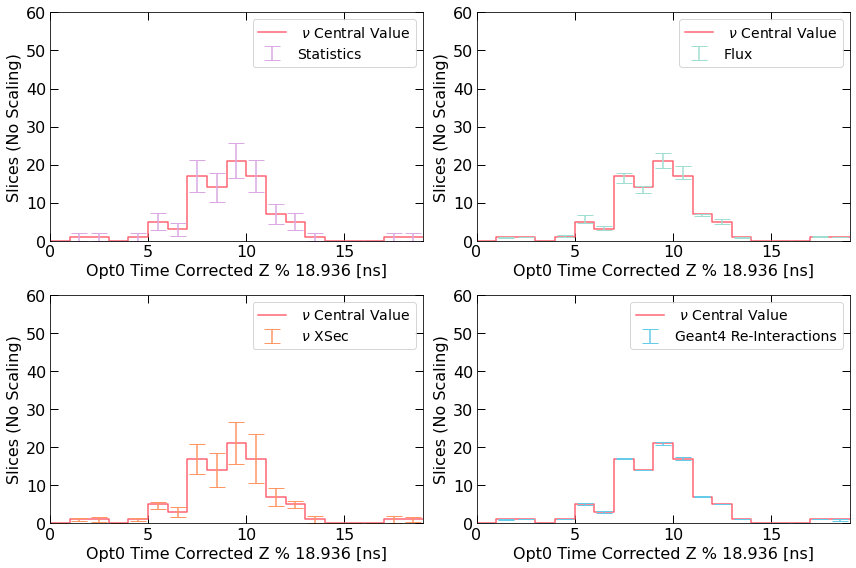

In [82]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize = (12,8))#, sharey = True, sharex= True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#=========================================================================#
#STATS
#-----------------------------------------------------------------#
#central value
ax1.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = r" $\nu$ Central Value")

ax1.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_stat_err'],nu_dict['pos_stat_err']]
            , ls='none'
            , color = col_dict['Lavender']
            , capsize=8
            , label = "Statistics"
           )
#-----------------------------------------------------------------#
ax1.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(nu_ymin, nu_ymax)

#=========================================================================#
#FLUX
#-----------------------------------------------------------------#
#central value
ax2.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = r" $\nu$ Central Value")

#-----------------------------------------------------------------#
#universe 1 sigma
ax2.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_flx_err'],nu_dict['pos_flx_err']]
            , ls='none'
            , color = col_dict['PastelGreen']
            , capsize=8
            , label = "Flux"
           )

#-----------------------------------------------------------------#
ax2.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax2.set_xlim(xmin, xmax)
ax2.set_ylim(nu_ymin, nu_ymax)

#=========================================================================#
#XSEC
#-----------------------------------------------------------------#
#central value
ax3.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = r" $\nu$ Central Value")

#-----------------------------------------------------------------#
#universe 1 sigma
ax3.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_xsec_quadSum'],nu_dict['pos_xsec_quadSum']]
            , ls='none'
            , color = col_dict['Peach']
            , capsize=8
            , label = r" $\nu$ XSec"
           )

#-----------------------------------------------------------------#
ax3.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax3, 16)
plot_title(ax3, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax3.set_xlim(xmin, xmax)
ax3.set_ylim(nu_ymin, nu_ymax)
#=========================================================================#
#G4
#-----------------------------------------------------------------#
#central value
ax4.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = r" $\nu$ Central Value")

#-----------------------------------------------------------------#
#universe 1 sigma
ax4.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_g4_err'],nu_dict['pos_g4_err']]
            , ls='none'
            , color = col_dict['SkyBlue']
            , capsize=8
            , label = "Geant4 Re-Interactions"
           )

#-----------------------------------------------------------------#
ax4.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax4, 16)
plot_title(ax4, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax4.set_xlim(xmin, xmax)
ax4.set_ylim(nu_ymin, nu_ymax)
#=========================================================================#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_standard_error.png"), dpi=200)
    
plt.show()

In [83]:
nu_dict['neg_stat_err'] = nu_dict['neg_stat_err'].reshape(1,19)
nu_dict['neg_flx_err'] = nu_dict['neg_flx_err'].reshape(1,19)
nu_dict['neg_xsec_quadSum'] = nu_dict['neg_xsec_quadSum'].reshape(1,19)
nu_dict['neg_g4_err'] = nu_dict['neg_g4_err'].reshape(1,19)

nu_neg_err = np.append(nu_dict['neg_stat_err'], nu_dict['neg_flx_err'], axis=0)
nu_neg_err = np.append(nu_neg_err, nu_dict['neg_xsec_quadSum'], axis=0)
nu_neg_err = np.append(nu_neg_err, nu_dict['neg_g4_err'], axis=0)

print("\n Negative Direction")
print(nu_neg_err)

#------------------------------------------------------------------#

nu_dict['pos_stat_err'] = nu_dict['pos_stat_err'].reshape(1,19)
nu_dict['pos_flx_err'] = nu_dict['pos_flx_err'].reshape(1,19)
nu_dict['pos_xsec_quadSum'] = nu_dict['pos_xsec_quadSum'].reshape(1,19)
nu_dict['pos_g4_err'] = nu_dict['pos_g4_err'].reshape(1,19)

nu_pos_err = np.append(nu_dict['pos_stat_err'], nu_dict['pos_flx_err'], axis=0)
nu_pos_err = np.append(nu_pos_err, nu_dict['pos_xsec_quadSum'], axis=0)
nu_pos_err = np.append(nu_pos_err, nu_dict['pos_g4_err'], axis=0)

print("\n Positive Direction")
print(nu_pos_err)

#------------------------------------------------------------------#

nu_neg_quad_err = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_neg_err)

nu_dict['neg_quadSum_err'] = nu_neg_quad_err
#------------------------------------------------------------------#

nu_pos_quad_err = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_pos_err)

nu_dict['pos_quadSum_err'] = nu_pos_quad_err


 Negative Direction
[[0.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 2.23606798e+00 1.73205081e+00 4.12310563e+00
  3.74165739e+00 4.58257569e+00 4.12310563e+00 2.64575131e+00
  2.23606798e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.93398394e-01 2.71158985e-02 0.00000000e+00
  6.77910491e-02 4.33614708e-01 1.32432988e-01 1.72575762e+00
  1.50858792e+00 1.95320662e+00 7.80768254e-01 5.84110079e-01
  4.96998631e-01 2.76604678e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.63438705e-02 1.06058171e-01]
 [0.00000000e+00 3.78758786e-01 5.53278876e-01 0.00000000e+00
  5.00763873e-01 1.15183107e+00 1.29059031e+00 4.13276050e+00
  4.50736145e+00 5.50371390e+00 6.47525362e+00 2.36760152e+00
  1.04684238e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 6.30140365e-01]
 [0.00000000e+00 1.47206128e-02 4.90143138e-04 0.00000000e+00
  0.00000000e+00 2.35022804e-

In [84]:
nu_dict.keys()
print(nu_dict['neg_quadSum_err'])
print(nu_dict['pos_quadSum_err'])

[0.         1.08677406 1.14317673 0.         1.12042853 2.56319571
 2.17356478 6.08916707 6.0499267  7.43639581 7.73042886 3.601294
 2.51851782 1.44101011 0.         0.         0.         1.41445891
 1.21610037]
[0.         1.04261963 1.13410746 0.         1.2210123  3.00053841
 2.34261123 5.59667932 5.76145947 7.58275857 8.00026433 3.54028066
 2.52855511 1.41526969 0.         0.         0.         1.41915985
 1.1930262 ]


In [85]:
#FOR PLOTTING

#Stat
nu_stat_neg_diff = nu_dict['neg_stat_err'] / nu_dict['nu_cv']
nu_stat_neg_diff = np.insert(nu_stat_neg_diff, 0, 0)
nu_stat_neg_diff[np.isnan(nu_stat_neg_diff)] = 0

nu_stat_pos_diff = nu_dict['pos_stat_err'] / nu_dict['nu_cv']
nu_stat_pos_diff = np.insert(nu_stat_pos_diff, 0, 0)
nu_stat_pos_diff[np.isnan(nu_stat_pos_diff)] = 0

#Flux
nu_flx_neg_diff = nu_dict['neg_flx_err'] / nu_dict['nu_cv']
nu_flx_neg_diff = np.insert(nu_flx_neg_diff, 0, 0)
nu_flx_neg_diff[np.isnan(nu_flx_neg_diff)] = 0

nu_flx_pos_diff = nu_dict['pos_flx_err'] / nu_dict['nu_cv']
nu_flx_pos_diff = np.insert(nu_flx_pos_diff, 0, 0)
nu_flx_pos_diff[np.isnan(nu_flx_pos_diff)] = 0

#Quad Sum
nu_quadsum_neg_diff = nu_dict['neg_quadSum_err'] / nu_dict['nu_cv']
nu_quadsum_neg_diff = np.insert(nu_quadsum_neg_diff, 0, 0)
nu_quadsum_neg_diff[np.isnan(nu_quadsum_neg_diff)] = 0

nu_quadsum_pos_diff = nu_dict['pos_quadSum_err'] / nu_dict['nu_cv']
nu_quadsum_pos_diff = np.insert(nu_quadsum_pos_diff, 0, 0)
nu_quadsum_pos_diff[np.isnan(nu_quadsum_pos_diff)] = 0

#XSec
nu_xsec_neg_diff = nu_dict['neg_xsec_quadSum'] / nu_dict['nu_cv']
nu_xsec_neg_diff = np.insert(nu_xsec_neg_diff, 0, 0)
nu_xsec_neg_diff[np.isnan(nu_xsec_neg_diff)] = 0

nu_xsec_pos_diff = nu_dict['pos_xsec_quadSum'] / nu_dict['nu_cv']
nu_xsec_pos_diff = np.insert(nu_xsec_pos_diff, 0, 0)
nu_xsec_pos_diff[np.isnan(nu_xsec_pos_diff)] = 0

#G4
nu_g4_neg_diff = nu_dict['neg_g4_err'] / nu_dict['nu_cv']
nu_g4_neg_diff = np.insert(nu_g4_neg_diff, 0, 0)
nu_g4_neg_diff[np.isnan(nu_g4_neg_diff)] = 0

nu_g4_pos_diff = nu_dict['pos_g4_err'] / nu_dict['nu_cv']
nu_g4_pos_diff = np.insert(nu_g4_pos_diff, 0, 0)
nu_g4_pos_diff[np.isnan(nu_g4_pos_diff)] = 0

In [91]:
print(nu_dict['neg_stat_err'] / nu_dict['nu_cv'])
print(nu_dict['pos_stat_err'] / nu_dict['nu_cv'])

[[       nan 1.         1.                nan 1.         0.4472136
  0.57735027 0.24253563 0.26726124 0.21821789 0.24253563 0.37796447
  0.4472136  1.                nan        nan        nan 1.
  1.        ]]
[[       nan 1.         1.                nan 1.         0.4472136
  0.57735027 0.24253563 0.26726124 0.21821789 0.24253563 0.37796447
  0.4472136  1.                nan        nan        nan 1.
  1.        ]]


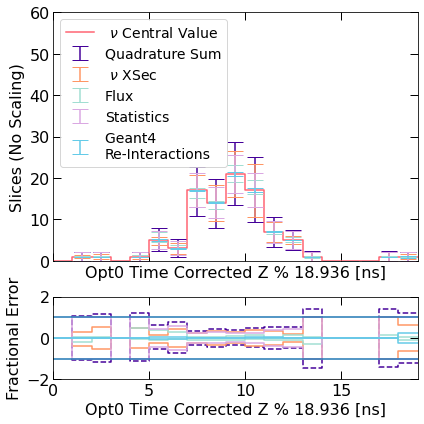

In [112]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize = (6, 6), sharex = True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax

#-----------------------------------------------------------------#
#central value
ax1.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = r" $\nu$ Central Value")
#=========================================================================#
#QuadSum
ax1.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_quadSum_err'],nu_dict['pos_quadSum_err']]
            , ls='none'
            , color = col_dict['DeepViolet']
            , capsize=8
            , label = "Quadrature Sum"
           )

#=========================================================================#
#XSEC
ax1.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_xsec_quadSum'].flatten(),nu_dict['pos_xsec_quadSum'].flatten()]
            , ls='none'
            , color = col_dict['Peach']
            , capsize=8
            , label = r" $\nu$ XSec"
           )

#=========================================================================#
#FLUX
ax1.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_flx_err'].flatten(),nu_dict['pos_flx_err'].flatten()]
            , ls='none'
            , color = col_dict['PastelGreen']
            , capsize=8
            , label = "Flux"
           )

#=========================================================================#
#STATS
ax1.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_stat_err'].flatten(),nu_dict['pos_stat_err'].flatten()]
            , ls='none'
            , color = col_dict['Lavender']
            , capsize=8
            , label = "Statistics"
           )
#=========================================================================#
#G4
ax1.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_g4_err'].flatten(),nu_dict['pos_g4_err'].flatten()]
            , ls='none'
            , color = col_dict['SkyBlue']
            , capsize=8
            , label = "Geant4 \nRe-Interactions"
           )
#-----------------------------------------------------------------#
ax1.legend(loc = 'upper left',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(nu_ymin, nu_ymax)
#=========================================================================#
#-----------------------------------------------------------------#
#QuadSum
ax2.step(bins, nu_quadsum_neg_diff * -1
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )

ax2.step(bins, nu_quadsum_pos_diff
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )
#-----------------------------------------------------------------#
#XSec
ax2.step(bins, nu_xsec_neg_diff * -1
         , color = col_dict['Peach'] 
        )

ax2.step(bins, nu_xsec_pos_diff
         , color = col_dict['Peach'] 
        )
#-----------------------------------------------------------------#
#Flux
ax2.step(bins, nu_flx_neg_diff * -1
         , color = col_dict['PastelGreen']
        )

ax2.step(bins, nu_flx_pos_diff
         , color = col_dict['PastelGreen']
        )
#-----------------------------------------------------------------#
#STATS
ax2.step(bins, nu_stat_neg_diff * -1
         , color = col_dict['Lavender']
        )

ax2.step(bins, nu_stat_pos_diff
         , color = col_dict['Lavender']
        )

#-----------------------------------------------------------------#
#G4
ax2.step(bins, nu_g4_neg_diff * -1
         , color = col_dict['SkyBlue']
        )

ax2.step(bins, nu_g4_pos_diff
         , color = col_dict['SkyBlue']
        )
#-----------------------------------------------------------------#

#ax2.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Fractional Error", 16)


ax2.set_xlim(xmin, xmax)
ax2.set_ylim(-2, 2)
ax2.axhline(y=1)
ax2.axhline(y=-1)
#=========================================================================#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_combined_standard_error.png"), dpi=200)
    
plt.show()

<h3>Scale To POT ONLY</h3>

In [93]:
scale_factor_nu = df_nu['scale_pot'].unique()[0]
print(scale_factor_nu)

88.43293673468362


In [107]:
hnl_quadsum_neg_diff[1:] * hnl_dict['hnl_cv'] * scale_factor

array([1.25180889, 1.11291977, 1.16710611, 0.97696341, 0.83968061,
       0.76865131, 0.84939846, 1.13669375, 1.41077933, 1.84166723,
       2.53237307, 2.85278206, 3.14492369, 3.26006592, 2.53846359,
       2.0477624 , 1.73062434, 1.67039701, 1.23763444])

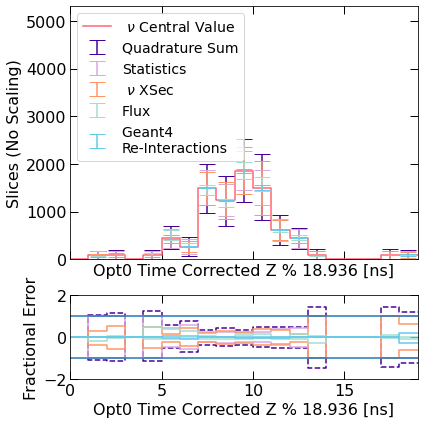

In [117]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize = (6, 6), sharex = True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax

#-----------------------------------------------------------------#
#central value
ax1.step(bins, nu_dict['nu_cv_plot'] * scale_factor_nu
         , color = col_dict['Flamingo'], label = r" $\nu$ Central Value")
#=========================================================================#
#QuadSum
ax1.errorbar(bins_mid, nu_dict['nu_cv'] * scale_factor_nu
            , [nu_quadsum_neg_diff[1:] * scale_factor_nu * nu_dict['nu_cv']
               , nu_quadsum_pos_diff[1:]  * scale_factor_nu * nu_dict['nu_cv']]
            , ls='none'
            , color = col_dict['DeepViolet']
            , capsize=8
            , label = "Quadrature Sum"
           )

#=========================================================================#
#STATS
ax1.errorbar(bins_mid, nu_dict['nu_cv']  * scale_factor_nu
            , [nu_stat_neg_diff[1:] * scale_factor_nu * nu_dict['nu_cv']
               ,nu_stat_pos_diff[1:] * scale_factor_nu * nu_dict['nu_cv']]
            , ls='none'
            , color = col_dict['Lavender']
            , capsize=8
            , label = "Statistics"
           )
#=========================================================================#
#XSEC
ax1.errorbar(bins_mid, nu_dict['nu_cv']  * scale_factor_nu
            , [nu_xsec_neg_diff[1:] * scale_factor_nu * nu_dict['nu_cv']
               ,nu_xsec_pos_diff[1:] * scale_factor_nu * nu_dict['nu_cv']]
            , ls='none'
            , color = col_dict['Peach']
            , capsize=8
            , label = r" $\nu$ XSec"
           )

#=========================================================================#
#FLUX
ax1.errorbar(bins_mid, nu_dict['nu_cv']  * scale_factor_nu
            , [nu_flx_neg_diff[1:] * scale_factor_nu * nu_dict['nu_cv']
               ,nu_flx_pos_diff[1:] * scale_factor_nu * nu_dict['nu_cv']]
            , ls='none'
            , color = col_dict['PastelGreen']
            , capsize=8
            , label = "Flux"
           )

#=========================================================================#
#G4
ax1.errorbar(bins_mid, nu_dict['nu_cv']  * scale_factor_nu
            , [nu_g4_neg_diff[1:] * scale_factor_nu * nu_dict['nu_cv']
               ,nu_g4_pos_diff[1:] * scale_factor_nu * nu_dict['nu_cv']]
            , ls='none'
            , color = col_dict['SkyBlue']
            , capsize=8
            , label = "Geant4 \nRe-Interactions"
           )
#-----------------------------------------------------------------#
ax1.legend(loc = 'upper left',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (No Scaling)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(nu_ymin, nu_ymax * scale_factor_nu)
#=========================================================================#
#-----------------------------------------------------------------#
#QuadSum
ax2.step(bins, nu_quadsum_neg_diff * -1
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )

ax2.step(bins, nu_quadsum_pos_diff
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )
#-----------------------------------------------------------------#
#STATS
ax2.step(bins, nu_stat_neg_diff * -1
         , color = col_dict['Lavender']
        )

ax2.step(bins, nu_stat_pos_diff
         , color = col_dict['Lavender']
        )

#-----------------------------------------------------------------#
#XSec
ax2.step(bins, nu_xsec_neg_diff * -1
         , color = col_dict['Peach'] 
        )

ax2.step(bins, nu_xsec_pos_diff
         , color = col_dict['Peach'] 
        )
#-----------------------------------------------------------------#
#Flux
ax2.step(bins, nu_flx_neg_diff * -1
         , color = col_dict['PastelGreen']
        )

ax2.step(bins, nu_flx_pos_diff
         , color = col_dict['PastelGreen']
        )

#-----------------------------------------------------------------#
#G4
ax2.step(bins, nu_g4_neg_diff * -1
         , color = col_dict['SkyBlue']
        )

ax2.step(bins, nu_g4_pos_diff
         , color = col_dict['SkyBlue']
        )
#-----------------------------------------------------------------#

#ax2.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Fractional Error", 16)


ax2.set_xlim(xmin, xmax)
ax2.set_ylim(-2, 2)
ax2.axhline(y=1)
ax2.axhline(y=-1)
#=========================================================================#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_combined_standard_error_scalePOT.png"), dpi=200)
    
plt.show()

In [148]:
nu_dict['nu_cv_scale'] = nu_dict['nu_cv'] * scale_factor_nu

#quadSum
nu_dict['neg_quadSum_err_scale'] = nu_quadsum_neg_diff[1:] * scale_factor_nu * nu_dict['nu_cv']
nu_dict['pos_quadSum_err_scale'] = nu_quadsum_pos_diff[1:] * scale_factor_nu * nu_dict['nu_cv']

#stat
nu_dict['neg_stat_err_scale'] = nu_stat_neg_diff[1:] * scale_factor_nu * nu_dict['nu_cv']
nu_dict['pos_stat_err_scale'] = nu_stat_pos_diff[1:] * scale_factor_nu * nu_dict['nu_cv']

#stat
nu_dict['neg_stat_err_scale'] = nu_stat_neg_diff[1:] * scale_factor_nu * nu_dict['nu_cv']
nu_dict['pos_stat_err_scale'] = nu_stat_pos_diff[1:] * scale_factor_nu * nu_dict['nu_cv']

#flux
nu_dict['neg_flx_err_scale'] = nu_flx_neg_diff[1:] * scale_factor_nu * nu_dict['nu_cv']
nu_dict['pos_flx_err_scale'] = nu_flx_pos_diff[1:] * scale_factor_nu * nu_dict['nu_cv']

#g4
nu_dict['neg_g4_err_scale'] = nu_g4_neg_diff[1:] * scale_factor_nu * nu_dict['nu_cv']
nu_dict['pos_g4_err_scale'] = nu_g4_pos_diff[1:] * scale_factor_nu * nu_dict['nu_cv']

#xsec
nu_dict['neg_xsec_err_scale'] = nu_xsec_neg_diff[1:] * scale_factor_nu * nu_dict['nu_cv']
nu_dict['pos_xsec_err_scale'] = nu_xsec_pos_diff[1:] * scale_factor_nu * nu_dict['nu_cv']

<h1> Quadrature Sum 2 Directional Error Bars Into 1 </h1>

<h3>HNL</h3>

In [149]:
hnl_dict

{'hnl_cv': array([225., 210., 216., 181., 142., 136., 145., 193., 278., 390., 555.,
        665., 735., 756., 608., 499., 395., 357., 244.]),
 'hnl_cv_plot': array([  0., 225., 210., 216., 181., 142., 136., 145., 193., 278., 390.,
        555., 665., 735., 756., 608., 499., 395., 357., 244.]),
 'bins': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 'bins_mid': array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 'neg_stat_err': array([[15.        , 14.49137675, 14.69693846, 13.45362405, 11.91637529,
         11.66190379, 12.04159458, 13.89244399, 16.673332  , 19.74841766,
         23.55843798, 25.78759392, 27.11088342, 27.49545417, 24.65765601,
         22.3383079 , 19.87460691, 18.89444363, 15.62049935]]),
 'pos_stat_err': array([[15.        , 14.49137675, 14.69693846, 13.45362405, 11.91637529,
         11.66190379, 12.04159458, 13.89244

In [150]:
hnl_negpos_stat_arr = (hnl_dict['neg_stat_err_scale'], hnl_dict['pos_stat_err_scale'])
hnl_negpos_stat_arr = np.array(hnl_negpos_stat_arr)

hnl_dict['negpos_stat_err_scale'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=hnl_negpos_stat_arr)

#------------------------------------------------------------------#
hnl_negpos_flx_arr = (hnl_dict['neg_flx_err_scale'], hnl_dict['pos_flx_err_scale'])
hnl_negpos_flx_arr = np.array(hnl_negpos_flx_arr)

hnl_dict['negpos_flx_err_scale'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=hnl_negpos_flx_arr)

#------------------------------------------------------------------#
hnl_negpos_quadsum_arr = (hnl_dict['neg_quadSum_err_scale'], hnl_dict['pos_quadSum_err_scale'])
hnl_negpos_quadsum_arr = np.array(hnl_negpos_quadsum_arr)

hnl_dict['negpos_quadSum_err_scale'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=hnl_negpos_quadSum_arr)

#------------------------------------------------------------------#

print('\n Stat')
print(hnl_negpos_stat_arr)
print(hnl_dict['negpos_stat_err_scale'])

print('\n Flux')
print(hnl_negpos_flx_arr)
print(hnl_dict['negpos_flx_err_scale'])

print('\n QuadSum')
print(hnl_negpos_quadSum_arr)
print(hnl_dict['negpos_quadSum_err_scale'])


 Stat
[[0.89041927 0.86022674 0.87242915 0.79862441 0.70737134 0.69226559
  0.71480452 0.82467332 0.98975041 1.17229144 1.39845914 1.5307847
  1.60933687 1.63216548 1.46371014 1.32603065 1.1797822  1.12159845
  0.92725291]
 [0.89041927 0.86022674 0.87242915 0.79862441 0.70737134 0.69226559
  0.71480452 0.82467332 0.98975041 1.17229144 1.39845914 1.5307847
  1.60933687 1.63216548 1.46371014 1.32603065 1.1797822  1.12159845
  0.92725291]]
[1.25924301 1.21654432 1.23380113 1.12942547 1.00037415 0.97901139
 1.01088625 1.1662642  1.39971845 1.65787045 1.97771988 2.16485649
 2.27594602 2.30823056 2.06999873 1.87529053 1.66846398 1.58617973
 1.31133364]

 Flux
[[0.87987444 0.7061164  0.77524451 0.56272246 0.45242603 0.33405566
  0.45883793 0.78229572 1.00533201 1.42037704 2.1112142  2.40729385
  2.70195852 2.82206762 2.07396963 1.56044018 1.2661653  1.23783807
  0.81972011]
 [0.9980965  1.28573074 1.03254526 1.06242154 0.98418497 0.80518584
  0.73115658 0.93836758 1.18963677 1.72330901 2.261

<h3>Neutrino</h3>

In [151]:
nu_dict.keys()

dict_keys(['nu_cv', 'nu_cv_plot', 'bins', 'bins_mid', 'neg_stat_err', 'pos_stat_err', 'neg_flx_err', 'pos_flx_err', 'cov_flx_err', 'neg_xsec_multisigma', 'pos_xsec_multisigma', 'neg_xsec_multisim', 'pos_xsec_multisim', 'cov_xsec_multisim_err', 'neg_xsec_quadSum', 'pos_xsec_quadSum', 'neg_g4_err', 'pos_g4_err', 'cov_g4_multisim_err', 'neg_quadSum_err', 'pos_quadSum_err', 'nu_cv_scale', 'neg_quadSum_err_scale', 'pos_quadSum_err_scale', 'neg_stat_err_scale', 'pos_stat_err_scale', 'neg_flx_err_scale', 'pos_flx_err_scale', 'neg_g4_err_scale', 'pos_g4_err_scale', 'negpos_stat_err', 'negpos_flx_err', 'negpos_xsec_err', 'negpos_g4_err', 'negpos_quadSum_err', 'negpos_stat_err_scale', 'negpos_flx_err_scale', 'neg_xsec_err_scale', 'pos_xsec_err_scale'])

In [155]:
nu_negpos_stat_arr = [nu_dict['neg_stat_err_scale'], nu_dict['pos_stat_err_scale']]
nu_negpos_stat_arr = np.array(nu_negpos_stat_arr)

nu_dict['negpos_stat_err_scale'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_negpos_stat_arr)

#------------------------------------------------------------------#
nu_negpos_flx_arr = [nu_dict['neg_flx_err_scale'], nu_dict['pos_flx_err_scale']]
nu_negpos_flx_arr = np.array(nu_negpos_flx_arr)

nu_dict['negpos_flx_err_scale'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_negpos_flx_arr)

#------------------------------------------------------------------#
nu_negpos_xsec_arr = [nu_dict['neg_xsec_err_scale'], nu_dict['pos_xsec_err_scale']]
nu_negpos_xsec_arr = np.array(nu_negpos_xsec_arr)

nu_dict['negpos_xsec_err_scale'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_negpos_xsec_arr)

#------------------------------------------------------------------#
nu_negpos_g4_arr = [nu_dict['neg_g4_err_scale'], nu_dict['pos_g4_err_scale']]
nu_negpos_g4_arr = np.array(nu_negpos_g4_arr)

nu_dict['negpos_g4_err_scale'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_negpos_g4_arr)

#------------------------------------------------------------------#
nu_negpos_quadSum_arr = [nu_dict['neg_quadSum_err_scale'], nu_dict['pos_quadSum_err_scale']]
nu_negpos_quadSum_arr = np.array(nu_negpos_quadSum_arr)

nu_dict['negpos_quadSum_err_scale'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_negpos_quadSum_arr)

#------------------------------------------------------------------#

print('\n Stat')
print(nu_negpos_stat_arr)
print(nu_dict['negpos_stat_err_scale'])

print('\n Flux')
print(nu_negpos_flx_arr)
print(nu_dict['negpos_flx_err_scale'])

print('\n XSec')
print(nu_negpos_xsec_arr)
print(nu_dict['negpos_xsec_err_scale'])

print('\n QuadSum')
print(nu_negpos_quadSum_arr)
print(nu_dict['negpos_quadSum_err_scale'])


 Stat
[[  0.          88.43293673  88.43293673   0.          88.43293673
  197.74205799 153.17033949 364.61833894 330.88575097 405.25062651
  364.61833894 233.97155831 197.74205799  88.43293673   0.
    0.           0.          88.43293673  88.43293673]
 [  0.          88.43293673  88.43293673   0.          88.43293673
  197.74205799 153.17033949 364.61833894 330.88575097 405.25062651
  364.61833894 233.97155831 197.74205799  88.43293673   0.
    0.           0.          88.43293673  88.43293673]]
[  0.         125.06305849 125.06305849   0.         125.06305849
 279.64950026 216.61557146 515.64820002 467.94311661 573.11093218
 515.64820002 330.88575097 279.64950026 125.06305849   0.
   0.           0.         125.06305849 125.06305849]

 Flux
[[  0.          17.10278793   2.39793854   0.           5.99496156
   38.34582203  11.71143801 152.6138145  133.40886036 172.72779729
   69.04562958  51.65456968  43.95104852  24.46096395   0.
    0.           0.           2.32966584   9.3790355

<h1>Save Array</h1>

In [157]:
hnl_dict.keys()

dict_keys(['hnl_cv', 'hnl_cv_plot', 'bins', 'bins_mid', 'neg_stat_err', 'pos_stat_err', 'neg_flx_err', 'pos_flx_err', 'cov_flx_err', 'neg_quadSum_err', 'pos_quadSum_err', 'hnl_cv_scale', 'neg_stat_err_scale', 'pos_stat_err_scale', 'neg_flx_err_scale', 'pos_flx_err_scale', 'neg_quadSum_err_scale', 'pos_quadSum_err_scale', 'negpos_stat_er_scaler', 'negpos_flx_err_scale', 'negpos_quadSum_err_scale', 'negpos_stat_er_scale', 'negpos_stat_err_scale'])

In [158]:
nu_dict.keys()

dict_keys(['nu_cv', 'nu_cv_plot', 'bins', 'bins_mid', 'neg_stat_err', 'pos_stat_err', 'neg_flx_err', 'pos_flx_err', 'cov_flx_err', 'neg_xsec_multisigma', 'pos_xsec_multisigma', 'neg_xsec_multisim', 'pos_xsec_multisim', 'cov_xsec_multisim_err', 'neg_xsec_quadSum', 'pos_xsec_quadSum', 'neg_g4_err', 'pos_g4_err', 'cov_g4_multisim_err', 'neg_quadSum_err', 'pos_quadSum_err', 'nu_cv_scale', 'neg_quadSum_err_scale', 'pos_quadSum_err_scale', 'neg_stat_err_scale', 'pos_stat_err_scale', 'neg_flx_err_scale', 'pos_flx_err_scale', 'neg_g4_err_scale', 'pos_g4_err_scale', 'negpos_stat_err', 'negpos_flx_err', 'negpos_xsec_err', 'negpos_g4_err', 'negpos_quadSum_err', 'negpos_stat_err_scale', 'negpos_flx_err_scale', 'neg_xsec_err_scale', 'pos_xsec_err_scale', 'negpos_xsec_err_scale', 'negpos_g4_err_scale', 'negpos_quadSum_err_scale'])

In [174]:
hnl_dict_save = {}
hnl_dict_save = {
    m :{ 
        'U': fitU,
        'bins': hnl_dict['bins'].tolist(),
        'sig': hnl_dict['hnl_cv_scale'].tolist(),
    
        'sig_stat': hnl_dict['pos_stat_err_scale'].tolist(),
    
        'sig_flx_lo': hnl_dict['hnl_cv_scale'] - hnl_dict['neg_flx_err_scale'].tolist(),
        'sig_flx_hi': hnl_dict['hnl_cv_scale'] + hnl_dict['pos_flx_err_scale'].tolist(),
        'sig_flx_quadSum': hnl_dict['negpos_flx_err_scale'].tolist(),

        'sig_quadSum_lo': (hnl_dict['hnl_cv_scale'] - hnl_dict['neg_quadSum_err_scale']).tolist(),
        'sig_quadSum_hi': (hnl_dict['hnl_cv_scale'] + hnl_dict['pos_quadSum_err_scale']).tolist(),
        'sig_quadSum': hnl_dict['negpos_quadSum_err_scale'].tolist(),
    
        'bkg': nu_dict['nu_cv_scale'].tolist(),
        
        'bkg_stat': nu_dict['pos_stat_err_scale'].tolist(),
        
        'bkg_flx_lo': nu_dict['nu_cv_scale'] - nu_dict['neg_flx_err_scale'].tolist(),
        'bkg_flx_hi': nu_dict['nu_cv_scale'] + nu_dict['pos_flx_err_scale'].tolist(),
        'bkg_flx_quadSum': nu_dict['negpos_flx_err_scale'].tolist(),
           
        'bkg_xsec_lo': nu_dict['nu_cv_scale'] - nu_dict['neg_xsec_err_scale'].tolist(),
        'bkg_xsec_hi': nu_dict['nu_cv_scale'] + nu_dict['pos_xsec_err_scale'].tolist(),
        'bkg_xsec_quadSum': nu_dict['negpos_xsec_err_scale'].tolist(),
        
        'bkg_g4_lo': nu_dict['nu_cv_scale'] - nu_dict['neg_g4_err_scale'].tolist(),
        'bkg_g4_hi': nu_dict['nu_cv_scale'] + nu_dict['pos_g4_err_scale'].tolist(),
        'bkg_g4_quadSum': nu_dict['negpos_g4_err_scale'].tolist(),
        
        'bkg_quadSum_lo': (nu_dict['nu_cv_scale'] - nu_dict['neg_quadSum_err_scale']).tolist(),
        'bkg_quadSum_hi': (nu_dict['nu_cv_scale'] + nu_dict['pos_quadSum_err_scale']).tolist(),
        'bkg_quadSum': nu_dict['negpos_quadSum_err_scale'].tolist()
        }
    
}

In [175]:
for k, v in hnl_dict_save[m].items():
    print(k ,v)
    print('\n')

U 1e-07


bins [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0]


sig [13.356289031301518, 12.465869762548083, 12.822037470049457, 10.744392509624777, 8.429302410865848, 8.073134703364474, 8.607386264616533, 11.456727924627524, 16.50243711423032, 23.1509009875893, 32.94551294387708, 39.47525424806893, 43.63054416891829, 44.8771311451731, 36.09166102680588, 29.621281007197588, 23.44770741050711, 21.191978596331744, 14.484153438389201]


sig_stat [0.8904192687534346, 0.8602267390381684, 0.8724291462352144, 0.7986244057385996, 0.7073713446643957, 0.6922655896459475, 0.7148045226315705, 0.8246733212189294, 0.9897504058398595, 1.1722914406793907, 1.3984591412025318, 1.5307847012000404, 1.609336866211311, 1.6321654797239364, 1.4637101356845514, 1.3260306525861025, 1.1797821970292717, 1.1215984452314518, 0.9272529073603404]


sig_flx_lo [12.47641459 11.75975336 12.04679296 10.18167005  7.97687638  7.73907904
  8.14854834 10.6744322

In [176]:
np.save("../pkl_files/m"+str(m)+"_v3.npy", hnl_dict_save) 

###### 